## Machine Learning Model Development to Detect Black Hole Nodes in an AODV network.

This Jupyter Notebook script loaded the training and test datasets that were created from running NS-3 network simulations that simulated AODV networks with black hole nodes that disrupt communication by capturing network data and discarding it rather than passing it along to the correct destination node. 

The NS-3 simulation produced .pcap network trace files for each node. All of these individual node trace files were imported into a script developed for this project that converted the AODV message observed in the nodes into a dataset with features that can be used to detect black hole nodes. These individual datasets were merged together into one large data set for each network simulation. 

As NS-3 simulations were not perfected, only one simulation is used for the training set and one for the test set.

With further development, it is recommended that several simulations be merged together to form the training and test datasets. Additionally, once the model training and testing is complete. A single network simulation can be used as a test dataset in order to find the malicious black hole nodes within that network.

In [1]:
# Import packages that will be used in this project.

from IPython.display import Image
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

# from skimage.io import imread, imshow

from pathlib import Path
from glob import glob
import os

import seaborn as sns

import pickle

# Import the required modules.
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#from sklearn.decomposition import PCA
#from sklearn import preprocessing

import time

from sklearn.model_selection import cross_val_score,KFold

In [2]:
# Display all columns in the pd data frame
pd.set_option('display.max_columns', None)

## <span style="color: darkblue;">1. Importing the Datasets</span>

The train and test .csv files are loaded.
As the data can be very easily produced from network simulations. Data collection is not an issue and so the data is not split into training and test sets, instead the training and the test data are separate network simulations.
<br>
<br>
As mentioned, ideally several simulations should be combined together for both the training and test set. Ensure that there are no duplicate Node IDs in the different sets. For the output in this current script, only one simulation was used for the training set and one for the test set.


In [3]:
# Read in the train and test sets
train =  pd.read_csv('./Datasets/Run_3_Train_2_sim_BHN_V.csv', index_col=0)
test = pd.read_csv('./Datasets/Run_3_Test_3_sim_BHN_V.csv', index_col=0)

## <span style="color: darkblue;">2. Exploring the Data</span>

In [4]:
train.shape

(616, 28)

In [5]:
train.head()

,Index,Node,Nbr_Node,Nbr_Count,Hello_Cnt,AODV_Msg_Nbr_Cnt,RREQs_Sent_To_Nbr,RREQs_From_Nbr,Nbr_Never_Sends_RREQ,Nbr_Is_Orig_Cnt,Nbr_Never_Orig,Nbr_Is_Dest_Cnt,Nbr_Never_Dest,All_RREPs_Rcvd_This_Node,RREPs_From_Nbr,RREP_Resp_Pct,Pct_Of_All_RREPs,Hop_Cnt_Over_1_Cnt,Hop_Cnt_Over_1_Pct,High_Dest_Seq_Num_Inc_Cnt,High_Dest_Seq_Num_Inc_Pct,Avg_Resp_Dly,Avg_Resp_Dly_Per_Hop,RERRs_From_Nbr,RERRs_From_Nbr_Pct,Pct_of_All_Nbrs,RREP_To_Nbrs_Ratio,Black_Hole_Node
0,1,10.1.1.0,10.1.1.45,44,25,0,181,0,True,0,True,0,True,621,0,0.00,0.00,0,NaN,0,NaN,NaN,NaN,0,NaN,2.27,0.000000,False
1,2,10.1.1.0,10.1.1.2,44,56,127,181,56,False,0,True,0,True,621,54,29.83,8.70,41,75.93,0,0.0,3.525608,0.946357,17,31.48,2.27,3.832599,False
2,3,10.1.1.0,10.1.1.1,44,151,262,181,149,False,5,False,0,True,621,69,38.12,11.11,31,44.93,0,0.0,1.826252,0.649025,44,63.77,2.27,4.894273,False
3,4,10.1.1.0,10.1.1.3,44,42,158,181,0,True,0,True,0,True,181,181,100.00,100.00,0,0.00,181,100.0,1.357565,0.553015,0,0.00,2.27,44.052863,True
4,5,10.1.1.0,10.1.1.31,44,24,49,181,24,False,0,True,0,True,621,15,8.29,2.42,8,53.33,0,0.0,0.502173,0.199722,10,66.67,2.27,1.066079,False


The datasets contain 28 features of which the last feature 'Black_Hole_Node' is the target variable. If it is flagged as True, the 1st tier neighbour node 'Nbr_Node' is a black hole node.

In [6]:
test.shape

(380, 28)

In [7]:
test.head()

,Index,Node,Nbr_Node,Nbr_Count,Hello_Cnt,AODV_Msg_Nbr_Cnt,RREQs_Sent_To_Nbr,RREQs_From_Nbr,Nbr_Never_Sends_RREQ,Nbr_Is_Orig_Cnt,Nbr_Never_Orig,Nbr_Is_Dest_Cnt,Nbr_Never_Dest,All_RREPs_Rcvd_This_Node,RREPs_From_Nbr,RREP_Resp_Pct,Pct_Of_All_RREPs,Hop_Cnt_Over_1_Cnt,Hop_Cnt_Over_1_Pct,High_Dest_Seq_Num_Inc_Cnt,High_Dest_Seq_Num_Inc_Pct,Avg_Resp_Dly,Avg_Resp_Dly_Per_Hop,RERRs_From_Nbr,RERRs_From_Nbr_Pct,Pct_of_All_Nbrs,RREP_To_Nbrs_Ratio,Black_Hole_Node
0,1,10.1.1.37,10.1.1.46,36,37,100,159,55,False,3,False,0,True,444,28,17.61,6.31,6,21.43,0,0.0,1.470976,0.913592,17,60.71,2.78,2.269784,False
1,2,10.1.1.37,10.1.1.26,36,44,15,159,11,False,0,True,0,True,444,3,1.89,0.68,2,66.67,0,0.0,0.364705,0.172806,1,33.33,2.78,0.244604,False
2,3,10.1.1.37,10.1.1.36,36,21,0,159,0,True,0,True,0,True,444,0,0.00,0.00,0,NaN,0,NaN,NaN,NaN,0,NaN,2.78,0.000000,False
3,4,10.1.1.37,10.1.1.38,36,155,219,159,136,False,0,True,0,True,444,51,32.08,11.49,23,45.10,0,0.0,1.969022,0.543309,32,62.75,2.78,4.133094,False
4,5,10.1.1.37,10.1.1.18,36,48,56,159,35,False,17,False,0,True,444,9,5.66,2.03,6,66.67,0,0.0,1.924230,0.413194,12,133.33,2.78,0.730216,False


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 616 entries, 0 to 615
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Index                      616 non-null    int64  
 1   Node                       616 non-null    object 
 2   Nbr_Node                   616 non-null    object 
 3   Nbr_Count                  616 non-null    int64  
 4   Hello_Cnt                  616 non-null    int64  
 5   AODV_Msg_Nbr_Cnt           616 non-null    int64  
 6   RREQs_Sent_To_Nbr          616 non-null    int64  
 7   RREQs_From_Nbr             616 non-null    int64  
 8   Nbr_Never_Sends_RREQ       616 non-null    bool   
 9   Nbr_Is_Orig_Cnt            616 non-null    int64  
 10  Nbr_Never_Orig             616 non-null    bool   
 11  Nbr_Is_Dest_Cnt            616 non-null    int64  
 12  Nbr_Never_Dest             616 non-null    bool   
 13  All_RREPs_Rcvd_This_Node   616 non-null    int64  

In [9]:
# Convert the boolean values to 1 or 0 for the training set.
train.Nbr_Never_Sends_RREQ = train.Nbr_Never_Sends_RREQ.replace( {True: 1, False: 0})
train.Nbr_Never_Orig = train.Nbr_Never_Orig.replace( {True: 1, False: 0})
train.Nbr_Never_Dest = train.Nbr_Never_Dest.replace( {True: 1, False: 0})
train.Black_Hole_Node = train.Black_Hole_Node.replace( {True: 1, False: 0})

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 616 entries, 0 to 615
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Index                      616 non-null    int64  
 1   Node                       616 non-null    object 
 2   Nbr_Node                   616 non-null    object 
 3   Nbr_Count                  616 non-null    int64  
 4   Hello_Cnt                  616 non-null    int64  
 5   AODV_Msg_Nbr_Cnt           616 non-null    int64  
 6   RREQs_Sent_To_Nbr          616 non-null    int64  
 7   RREQs_From_Nbr             616 non-null    int64  
 8   Nbr_Never_Sends_RREQ       616 non-null    int64  
 9   Nbr_Is_Orig_Cnt            616 non-null    int64  
 10  Nbr_Never_Orig             616 non-null    int64  
 11  Nbr_Is_Dest_Cnt            616 non-null    int64  
 12  Nbr_Never_Dest             616 non-null    int64  
 13  All_RREPs_Rcvd_This_Node   616 non-null    int64  

All features are now integers or floats apart from the Subject and Neighbour Node IDs.

In [11]:
# Convert the boolean values to 1 or 0 for the test set.
test.Nbr_Never_Sends_RREQ = test.Nbr_Never_Sends_RREQ.replace( {True: 1, False: 0})
test.Nbr_Never_Orig = test.Nbr_Never_Orig.replace( {True: 1, False: 0})
test.Nbr_Never_Dest = test.Nbr_Never_Dest.replace( {True: 1, False: 0})
test.Black_Hole_Node = test.Black_Hole_Node.replace( {True: 1, False: 0})

In [12]:
# Check for null values in the training set.
print(f'Null Values\n {train.isnull().sum()}')

Null Values
 Index                          0
Node                           0
Nbr_Node                       0
Nbr_Count                      0
Hello_Cnt                      0
AODV_Msg_Nbr_Cnt               0
RREQs_Sent_To_Nbr              0
RREQs_From_Nbr                 0
Nbr_Never_Sends_RREQ           0
Nbr_Is_Orig_Cnt                0
Nbr_Never_Orig                 0
Nbr_Is_Dest_Cnt                0
Nbr_Never_Dest                 0
All_RREPs_Rcvd_This_Node       0
RREPs_From_Nbr                 0
RREP_Resp_Pct                  0
Pct_Of_All_RREPs               0
Hop_Cnt_Over_1_Cnt             0
Hop_Cnt_Over_1_Pct           227
High_Dest_Seq_Num_Inc_Cnt      0
High_Dest_Seq_Num_Inc_Pct    227
Avg_Resp_Dly                 237
Avg_Resp_Dly_Per_Hop         237
RERRs_From_Nbr                 0
RERRs_From_Nbr_Pct           227
Pct_of_All_Nbrs                0
RREP_To_Nbrs_Ratio             0
Black_Hole_Node                0
dtype: int64


In [13]:
train['Black_Hole_Node']

0      0
1      0
2      0
3      1
4      0
      ..
611    1
612    0
613    0
614    0
615    0
Name: Black_Hole_Node, Length: 616, dtype: int64

Observing the features above, many have missing values. This can be explained by the fact that many 1st tier neighbours of the subject node were not initiating RREQ messages or they were never the destination and so they did not send any RREPs. This would result in RREPs_From_Nbr = 0. This feature was often used as a divisor for calculating percentages and so this would result in NA fields that were left blank when the dataset creation script was run. These are not really missing values but rather truly non applicable fields. For the machine learning to continue, these rows will be deleted so that there are no missing values. 

It is expected that a black hole node would almost always send an RREP when it receives and RREQ and it would also respond to an RREQ with a short hop count. So neighbours that don't respond to RREQ requests highly unlikely likely to be malicious nodes.

Importantly, there are no missing values in the target variable 'Black_Hole_Node'.

In [14]:
# Check for null values.
print(f'Null Values\n {test.isnull().sum()}')

Null Values
 Index                          0
Node                           0
Nbr_Node                       0
Nbr_Count                      0
Hello_Cnt                      0
AODV_Msg_Nbr_Cnt               0
RREQs_Sent_To_Nbr              0
RREQs_From_Nbr                 0
Nbr_Never_Sends_RREQ           0
Nbr_Is_Orig_Cnt                0
Nbr_Never_Orig                 0
Nbr_Is_Dest_Cnt                0
Nbr_Never_Dest                 0
All_RREPs_Rcvd_This_Node       0
RREPs_From_Nbr                 0
RREP_Resp_Pct                  0
Pct_Of_All_RREPs               0
Hop_Cnt_Over_1_Cnt             0
Hop_Cnt_Over_1_Pct           166
High_Dest_Seq_Num_Inc_Cnt      0
High_Dest_Seq_Num_Inc_Pct    166
Avg_Resp_Dly                 175
Avg_Resp_Dly_Per_Hop         175
RERRs_From_Nbr                 0
RERRs_From_Nbr_Pct           166
Pct_of_All_Nbrs                0
RREP_To_Nbrs_Ratio             0
Black_Hole_Node                0
dtype: int64


The same is true for the test dataset.

**Remove all the rows with missing values.**

In [15]:
train = train.dropna().reset_index(drop=True)
test = test.dropna().reset_index(drop=True)

In [16]:
train.head(10)

,Index,Node,Nbr_Node,Nbr_Count,Hello_Cnt,AODV_Msg_Nbr_Cnt,RREQs_Sent_To_Nbr,RREQs_From_Nbr,Nbr_Never_Sends_RREQ,Nbr_Is_Orig_Cnt,Nbr_Never_Orig,Nbr_Is_Dest_Cnt,Nbr_Never_Dest,All_RREPs_Rcvd_This_Node,RREPs_From_Nbr,RREP_Resp_Pct,Pct_Of_All_RREPs,Hop_Cnt_Over_1_Cnt,Hop_Cnt_Over_1_Pct,High_Dest_Seq_Num_Inc_Cnt,High_Dest_Seq_Num_Inc_Pct,Avg_Resp_Dly,Avg_Resp_Dly_Per_Hop,RERRs_From_Nbr,RERRs_From_Nbr_Pct,Pct_of_All_Nbrs,RREP_To_Nbrs_Ratio,Black_Hole_Node
0,2,10.1.1.0,10.1.1.2,44,56,127,181,56,0,0,1,0,1,621,54,29.83,8.70,41,75.93,0,0.0,3.525608,0.946357,17,31.48,2.27,3.832599,0
1,3,10.1.1.0,10.1.1.1,44,151,262,181,149,0,5,0,0,1,621,69,38.12,11.11,31,44.93,0,0.0,1.826252,0.649025,44,63.77,2.27,4.894273,0
2,4,10.1.1.0,10.1.1.3,44,42,158,181,0,1,0,1,0,1,181,181,100.00,100.00,0,0.00,181,100.0,1.357565,0.553015,0,0.00,2.27,44.052863,1
3,5,10.1.1.0,10.1.1.31,44,24,49,181,24,0,0,1,0,1,621,15,8.29,2.42,8,53.33,0,0.0,0.502173,0.199722,10,66.67,2.27,1.066079,0
4,10,10.1.1.0,10.1.1.18,44,30,20,181,14,0,10,0,0,1,621,3,1.66,0.48,1,33.33,0,0.0,0.956295,0.407157,3,100.00,2.27,0.211454,0
5,14,10.1.1.0,10.1.1.43,44,14,12,181,7,0,0,1,0,1,621,3,1.66,0.48,2,66.67,0,0.0,0.012493,0.005030,2,66.67,2.27,0.211454,0
6,16,10.1.1.0,10.1.1.37,44,28,24,181,10,0,1,0,0,1,621,11,6.08,1.77,10,90.91,0,0.0,2.379127,0.635758,3,27.27,2.27,0.779736,0
7,17,10.1.1.0,10.1.1.6,44,20,79,181,41,0,1,0,0,1,621,29,16.02,4.67,13,44.83,0,0.0,3.044343,1.182209,9,31.03,2.27,2.057269,0
8,18,10.1.1.0,10.1.1.8,44,26,32,181,19,0,0,1,0,1,621,10,5.52,1.61,7,70.00,0,0.0,2.760390,0.858879,3,30.00,2.27,0.709251,0
9,20,10.1.1.0,10.1.1.5,44,7,27,181,11,0,1,0,0,1,621,13,7.18,2.09,6,46.15,0,0.0,0.977783,0.339244,3,23.08,2.27,0.920705,0


In [17]:
# Confirm there are no null values in the train dataset.
print(f'Null Values\n {train.isnull().sum()}')

Null Values
 Index                        0
Node                         0
Nbr_Node                     0
Nbr_Count                    0
Hello_Cnt                    0
AODV_Msg_Nbr_Cnt             0
RREQs_Sent_To_Nbr            0
RREQs_From_Nbr               0
Nbr_Never_Sends_RREQ         0
Nbr_Is_Orig_Cnt              0
Nbr_Never_Orig               0
Nbr_Is_Dest_Cnt              0
Nbr_Never_Dest               0
All_RREPs_Rcvd_This_Node     0
RREPs_From_Nbr               0
RREP_Resp_Pct                0
Pct_Of_All_RREPs             0
Hop_Cnt_Over_1_Cnt           0
Hop_Cnt_Over_1_Pct           0
High_Dest_Seq_Num_Inc_Cnt    0
High_Dest_Seq_Num_Inc_Pct    0
Avg_Resp_Dly                 0
Avg_Resp_Dly_Per_Hop         0
RERRs_From_Nbr               0
RERRs_From_Nbr_Pct           0
Pct_of_All_Nbrs              0
RREP_To_Nbrs_Ratio           0
Black_Hole_Node              0
dtype: int64


In [18]:
train.shape

(379, 28)

In [19]:
test.shape

(205, 28)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Index                      379 non-null    int64  
 1   Node                       379 non-null    object 
 2   Nbr_Node                   379 non-null    object 
 3   Nbr_Count                  379 non-null    int64  
 4   Hello_Cnt                  379 non-null    int64  
 5   AODV_Msg_Nbr_Cnt           379 non-null    int64  
 6   RREQs_Sent_To_Nbr          379 non-null    int64  
 7   RREQs_From_Nbr             379 non-null    int64  
 8   Nbr_Never_Sends_RREQ       379 non-null    int64  
 9   Nbr_Is_Orig_Cnt            379 non-null    int64  
 10  Nbr_Never_Orig             379 non-null    int64  
 11  Nbr_Is_Dest_Cnt            379 non-null    int64  
 12  Nbr_Never_Dest             379 non-null    int64  
 13  All_RREPs_Rcvd_This_Node   379 non-null    int64  

The train and test sets now have 0 missing values and the modelling can proceed.

**Display the descriptive statistics of the AODV network dataset**

In [21]:
train.describe()

,Index,Nbr_Count,Hello_Cnt,AODV_Msg_Nbr_Cnt,RREQs_Sent_To_Nbr,RREQs_From_Nbr,Nbr_Never_Sends_RREQ,Nbr_Is_Orig_Cnt,Nbr_Never_Orig,Nbr_Is_Dest_Cnt,Nbr_Never_Dest,All_RREPs_Rcvd_This_Node,RREPs_From_Nbr,RREP_Resp_Pct,Pct_Of_All_RREPs,Hop_Cnt_Over_1_Cnt,Hop_Cnt_Over_1_Pct,High_Dest_Seq_Num_Inc_Cnt,High_Dest_Seq_Num_Inc_Pct,Avg_Resp_Dly,Avg_Resp_Dly_Per_Hop,RERRs_From_Nbr,RERRs_From_Nbr_Pct,Pct_of_All_Nbrs,RREP_To_Nbrs_Ratio,Black_Hole_Node
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.0,379.0,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,307.865435,41.860158,26.773087,86.197889,211.197889,38.612137,0.076517,2.952507,0.559367,0.0,1.0,652.474934,40.343008,19.006227,11.339683,18.005277,62.608100,16.319261,7.709578,2.310803,0.580999,17.501319,99.643193,2.422137,4.709195,0.076517
std,172.705090,4.703817,29.014614,80.525328,48.884059,41.781175,0.266175,7.952429,0.497119,0.0,0.0,288.253290,58.277012,26.359645,25.836704,23.308603,33.239949,58.158249,26.615386,1.214210,0.350209,18.141037,122.761706,0.301746,10.882014,0.266175
min,2.000000,32.000000,0.000000,4.000000,106.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,106.000000,1.000000,0.370000,0.100000,0.000000,0.000000,0.000000,0.000000,0.002137,0.001069,0.000000,0.000000,2.080000,0.044000,0.000000
25%,168.500000,40.000000,9.000000,33.000000,183.000000,14.000000,0.000000,0.000000,0.000000,0.0,1.0,442.000000,7.000000,3.615000,1.190000,2.000000,42.210000,0.000000,0.000000,1.528729,0.383634,4.000000,37.800000,2.130000,0.505306,0.000000
50%,307.000000,42.000000,19.000000,63.000000,231.000000,27.000000,0.000000,0.000000,1.000000,0.0,1.0,664.000000,19.000000,9.680000,3.080000,10.000000,73.910000,0.000000,0.000000,2.262241,0.579489,12.000000,77.360000,2.380000,1.304487,0.000000
75%,449.500000,47.000000,34.000000,105.500000,234.000000,47.000000,0.000000,2.000000,1.000000,0.0,1.0,874.000000,42.000000,19.960000,6.715000,26.000000,89.360000,0.000000,0.000000,3.234416,0.741284,24.500000,127.350000,2.500000,2.691914,0.000000
max,616.000000,48.000000,162.000000,485.000000,269.000000,256.000000,1.000000,65.000000,1.000000,0.0,1.0,1184.000000,269.000000,100.000000,100.000000,157.000000,100.000000,269.000000,100.000000,5.755343,2.877671,113.000000,1400.000000,3.120000,48.076923,1.000000


### Correlation Heatmaps

**The scale in the entire correlation heatmap is difficult to read so it has been split into two further below**

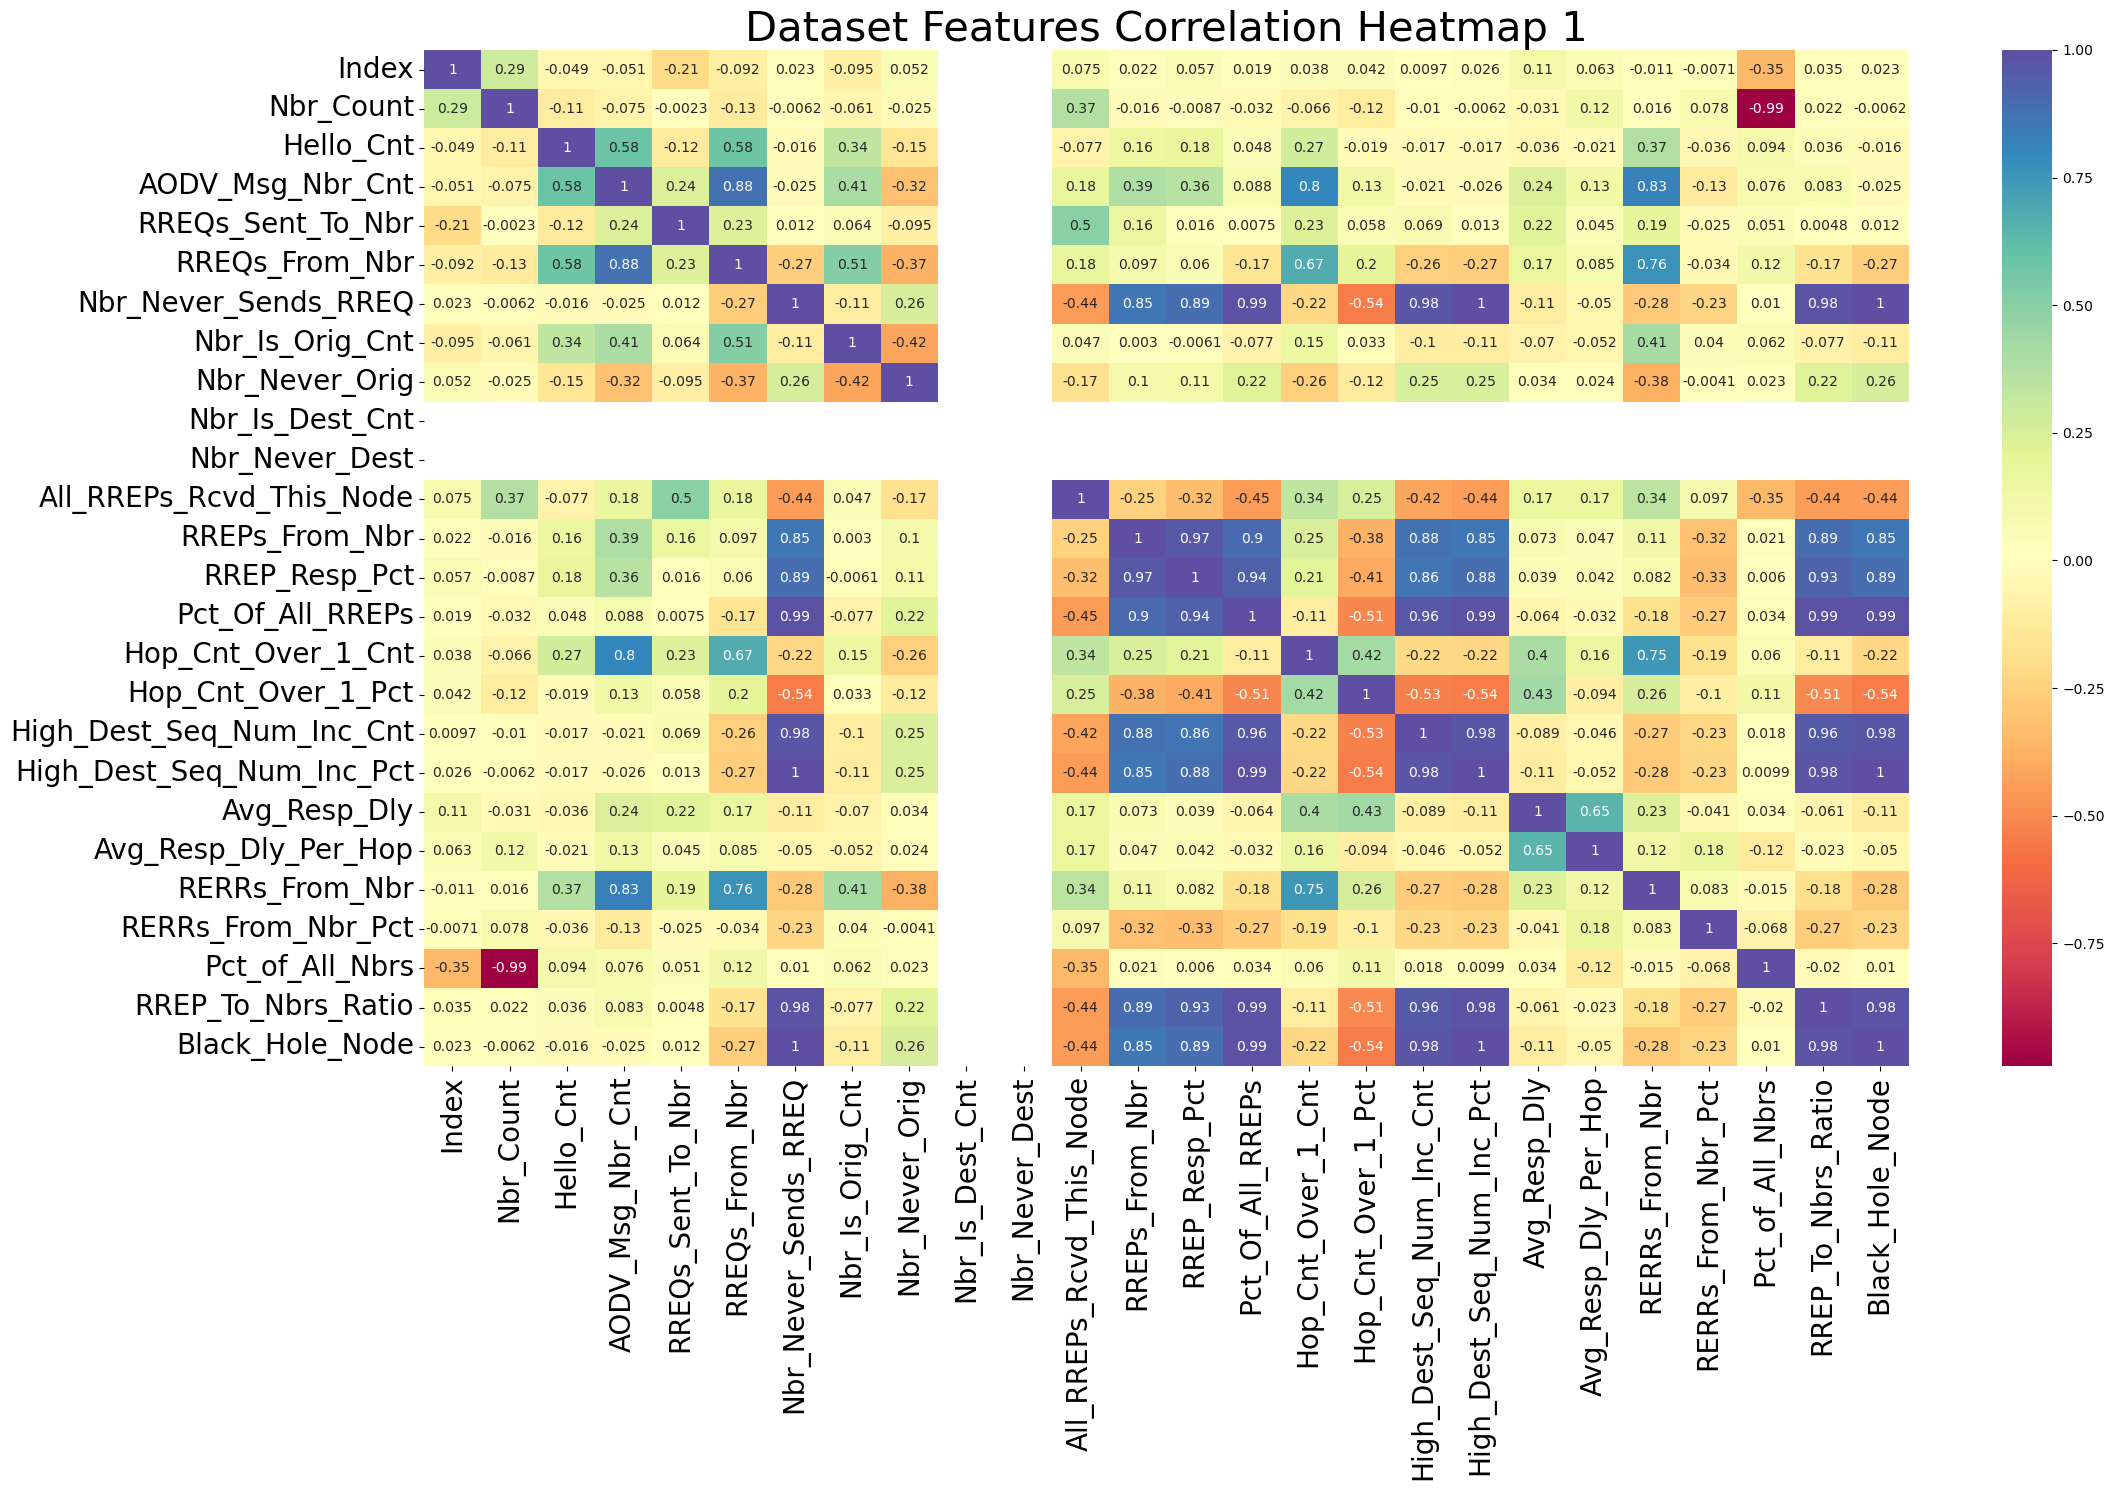

In [22]:
# Plot the 1st correlation Matrix
plt.rcParams["figure.figsize"] = [23, 15]
plt.rcParams["figure.autolayout"] = True
ax = sns.heatmap(train.corr(), annot=True, cmap='Spectral', annot_kws={'fontsize': 10})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 20)
ax.set_yticklabels(ax.get_xmajorticklabels(), fontsize = 20)
plt.title('Dataset Features Correlation Heatmap 1', fontsize=30)
plt.show()

In [23]:
# Remove non-numeric and irrelevant columns. 
# This will be the subject and neighbour node IDs as their ID numbers are irrelavent in detecting if a node is malicious.
# train_cm = train.drop(['Index'], axis = 1)
# Split the dataset into two so that the correlation matrix text will not be too small.
train_cm1 = train.iloc[:,[3,4,5,6,7,8,9,10,11,12,13,14,27]]
train_cm2 = train.iloc[:,[15,16,17,18,19,20,21,22,23,24,25,26,27]]

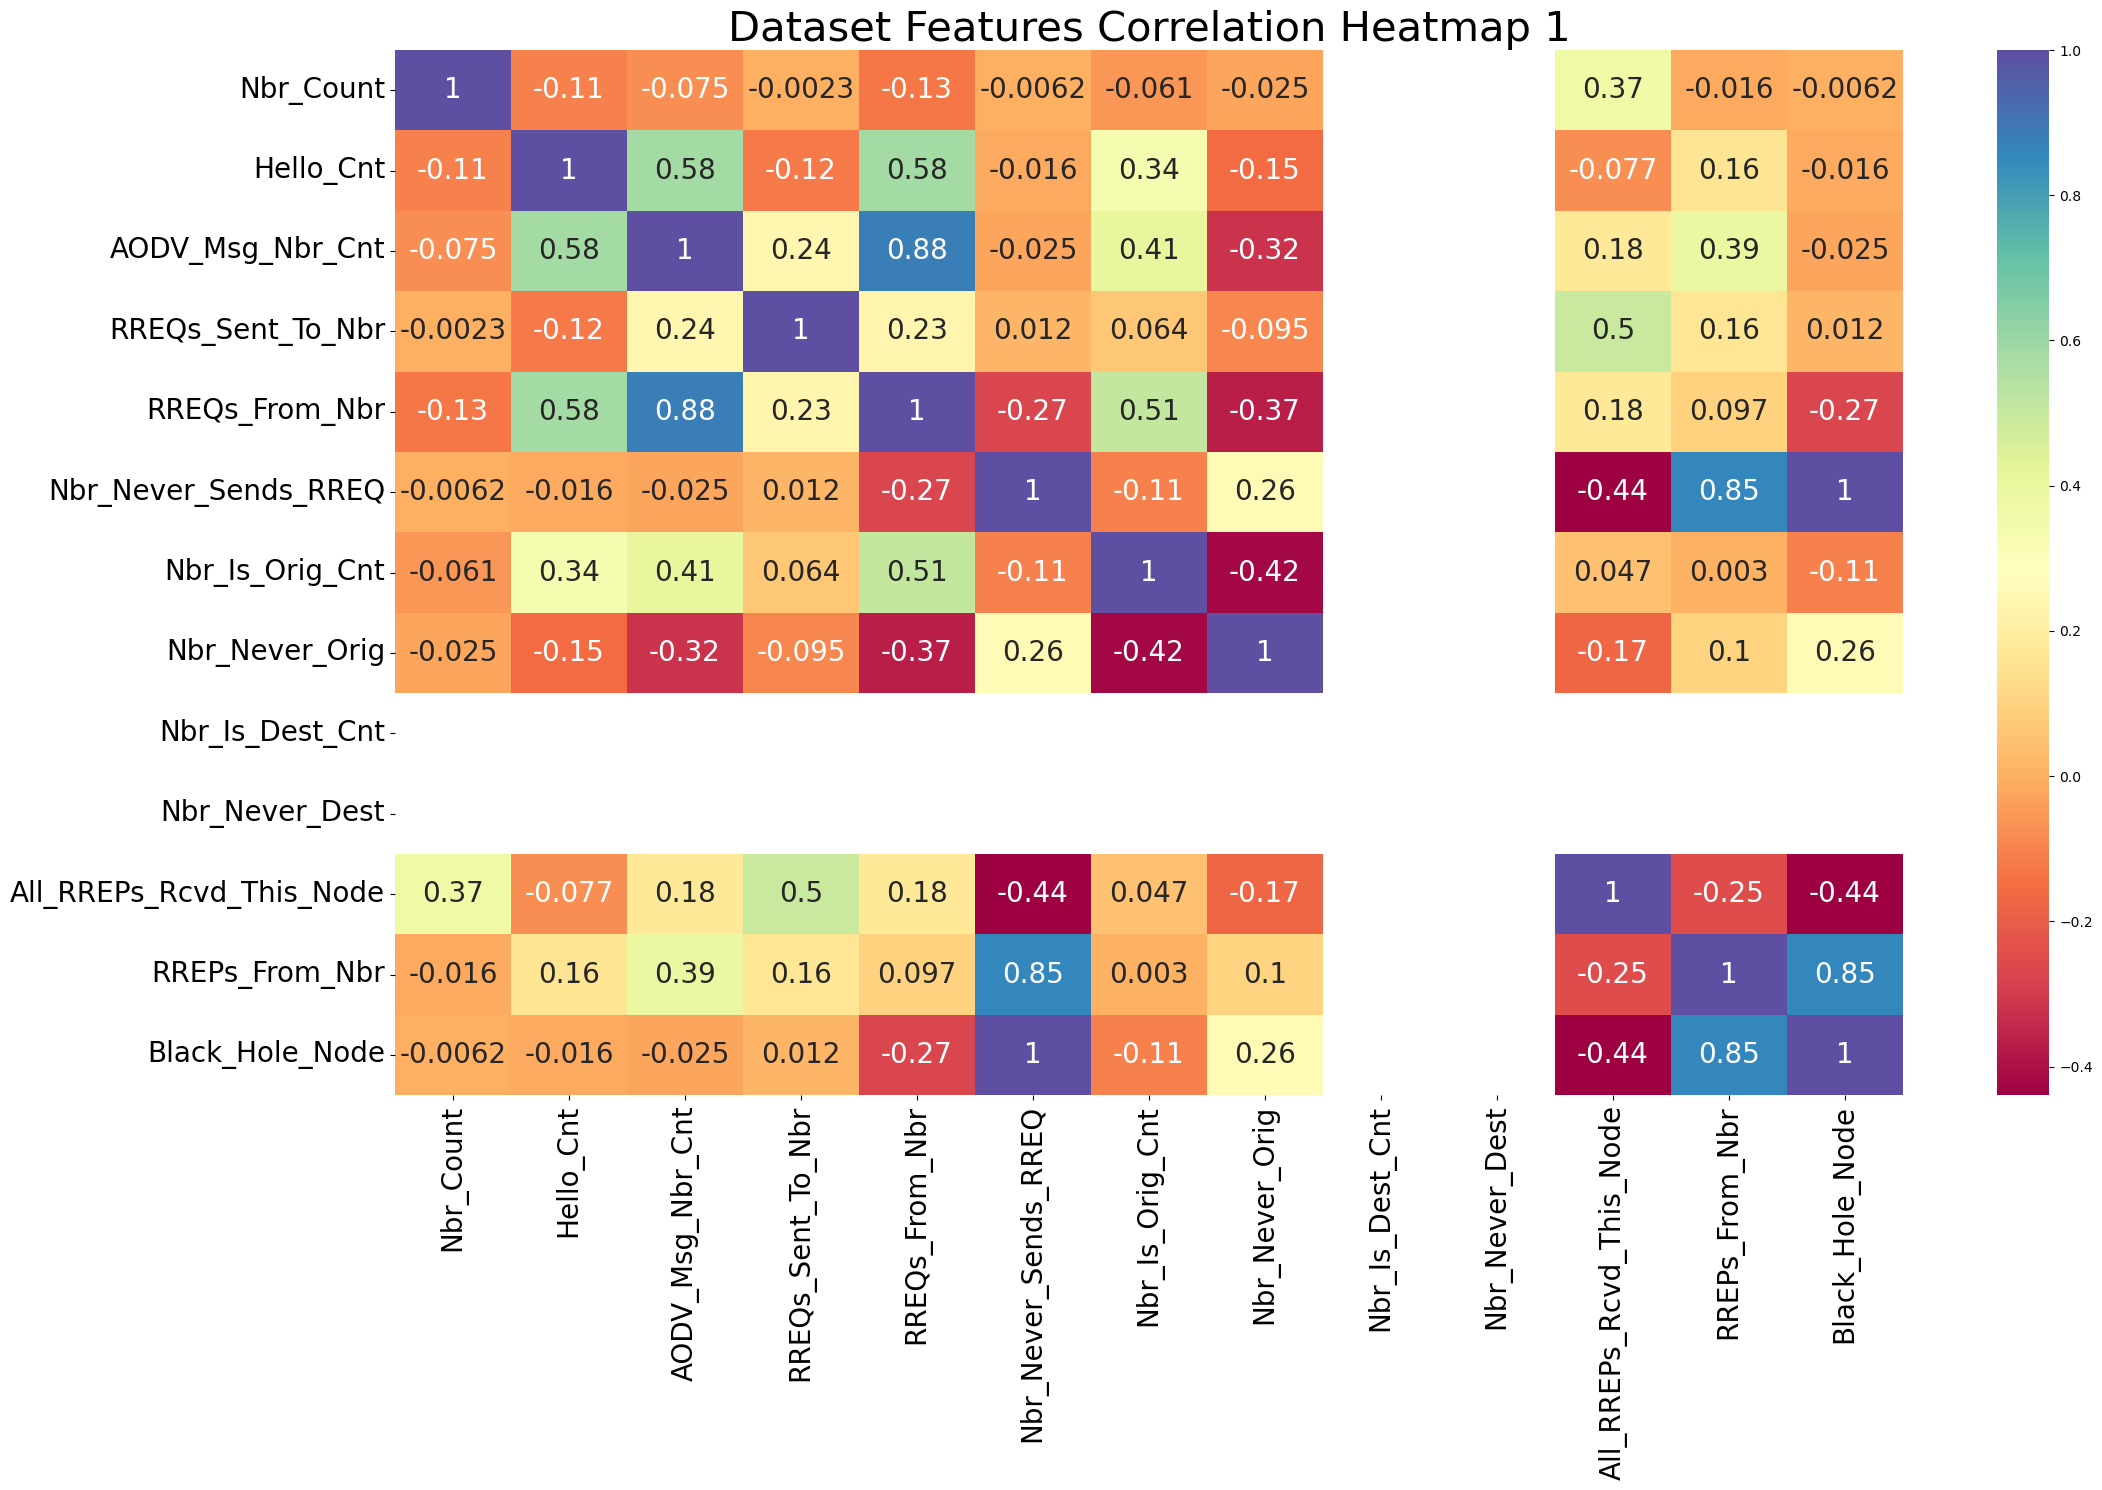

In [24]:
# Plot the 1st correlation Matrix
plt.rcParams["figure.figsize"] = [23, 15]
plt.rcParams["figure.autolayout"] = True
ax = sns.heatmap(train_cm1.corr(), annot=True, cmap='Spectral', annot_kws={'fontsize': 20})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 20)
ax.set_yticklabels(ax.get_xmajorticklabels(), fontsize = 20)
plt.title('Dataset Features Correlation Heatmap 1', fontsize=30)
plt.show()

It must be noted above that as there were issues with the simulations. The neighbour node was never the destination and so these fields were constant values which is why they are blank in the correlation matrix.

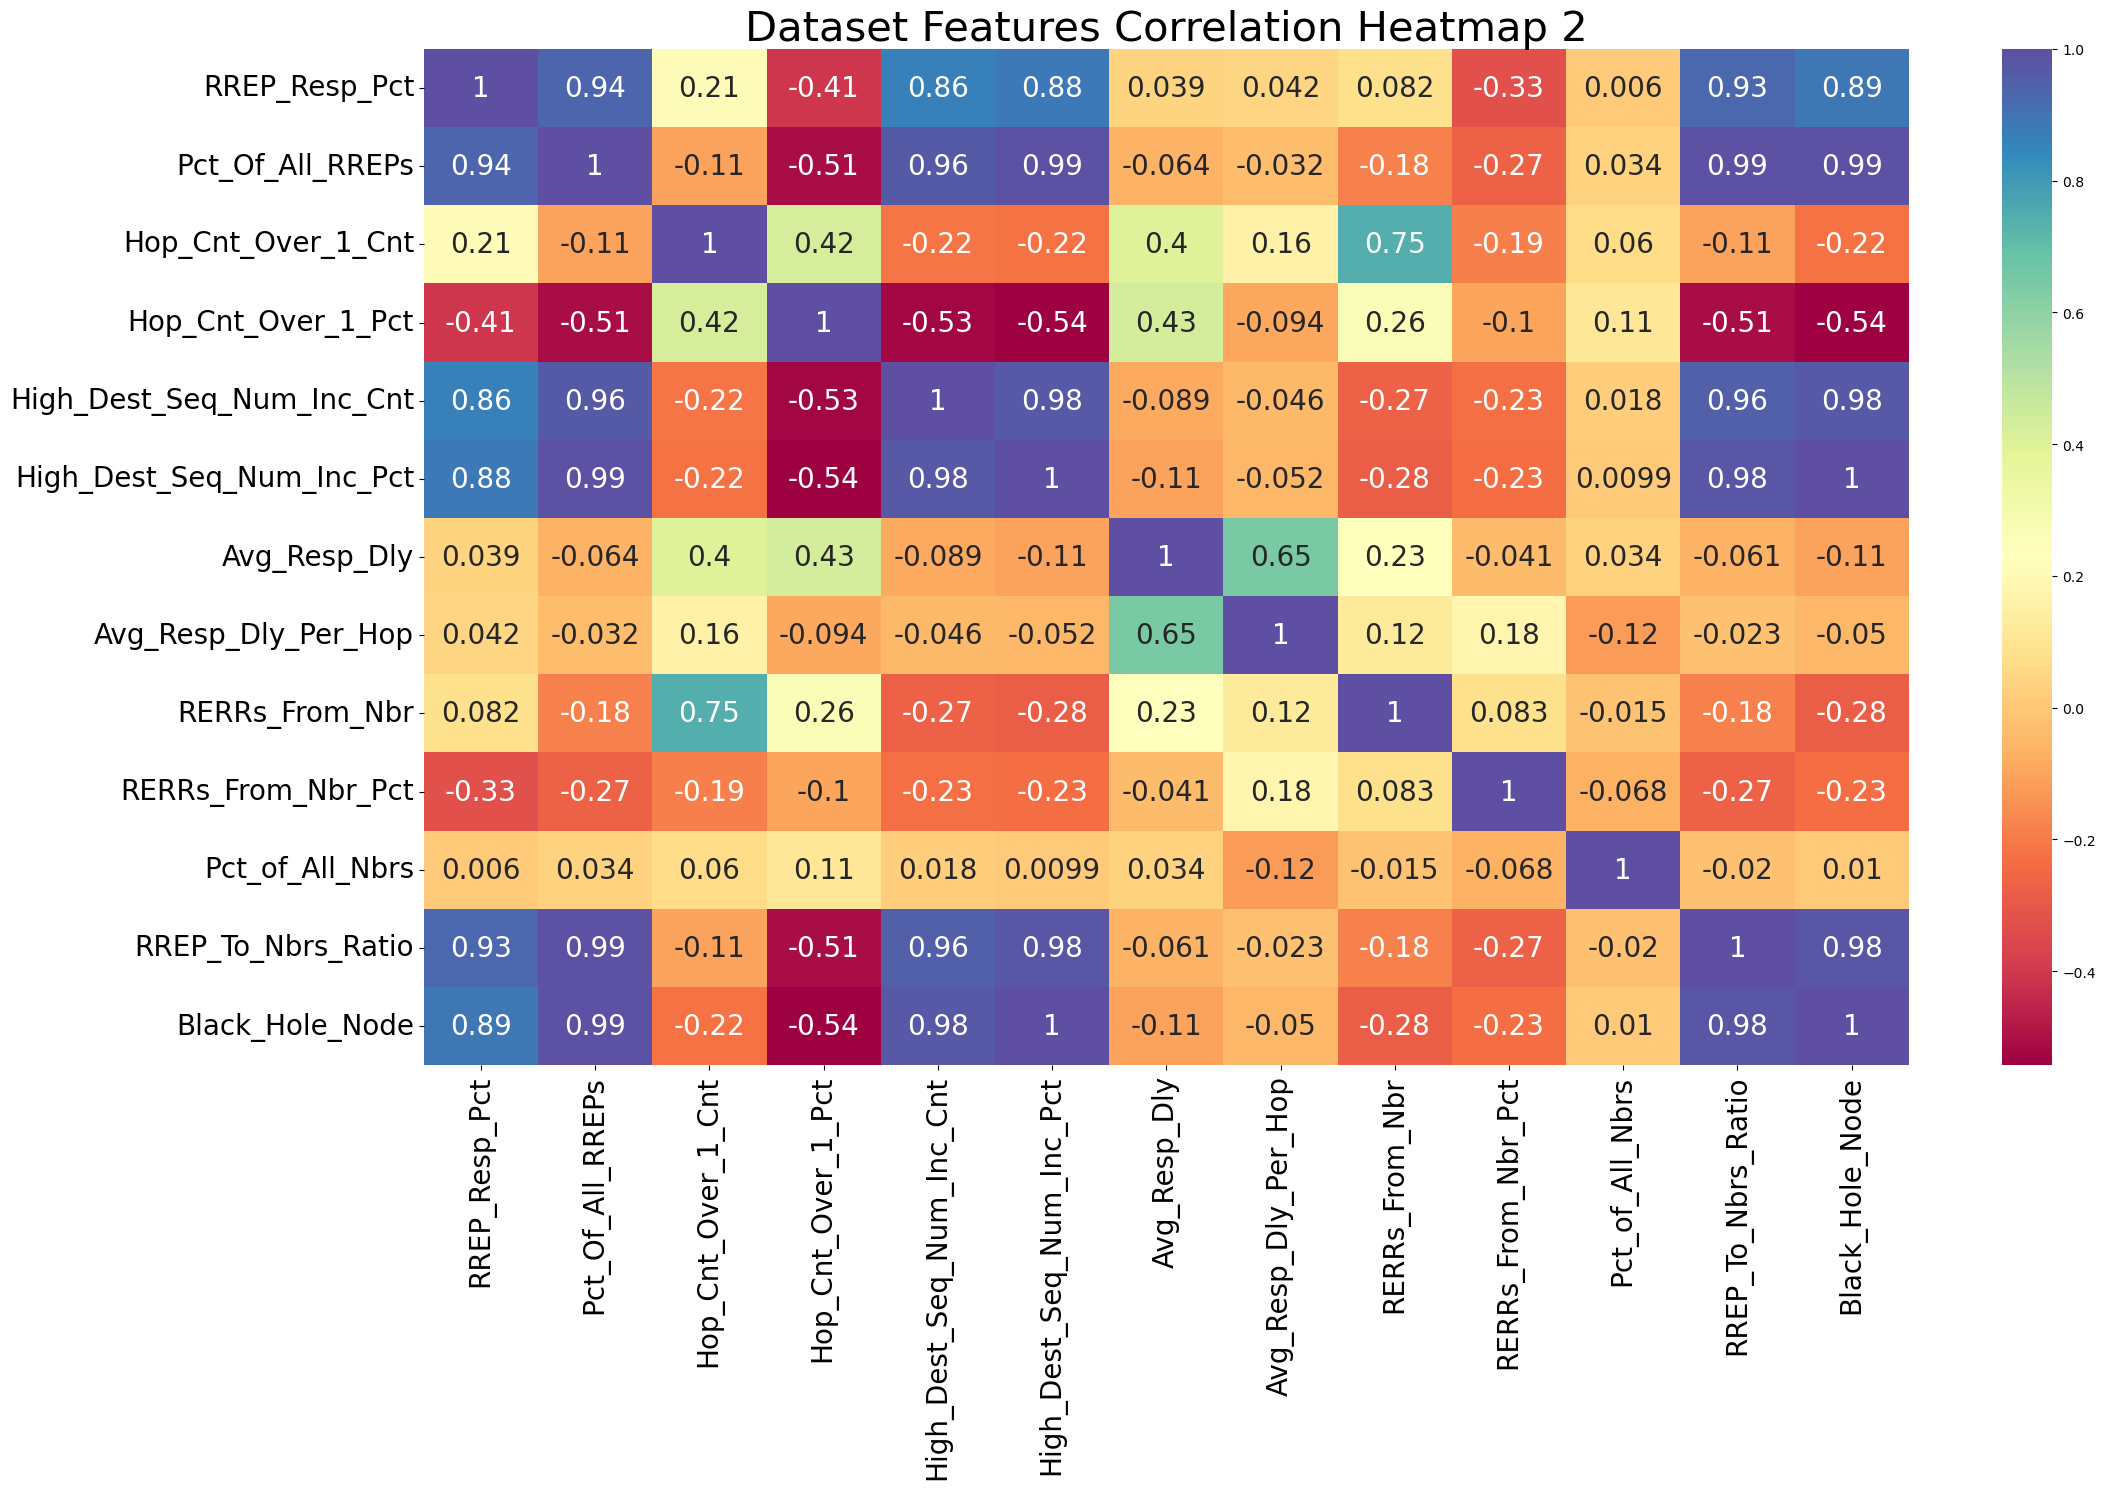

In [25]:
# Plot the 2nd correlation Matrix
plt.rcParams["figure.figsize"] = [23, 15]
plt.rcParams["figure.autolayout"] = True
ax = sns.heatmap(train_cm2.corr(), annot=True, cmap='Spectral', annot_kws={'fontsize': 20})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 20)
ax.set_yticklabels(ax.get_xmajorticklabels(), fontsize = 20)
plt.title('Dataset Features Correlation Heatmap 2', fontsize=30)
plt.show()

The correlation heatmaps above show which features correlate the strongest with the target variable in the final column. It can be clearly seen that the following variables have a strong correlation to black hole nodes:


**Nbr_Never_Sends_RREQ**<br>
**RREPs_From_Nbr**<br>
**RREP_Resp_Pct**<br>
**Pct_Of_All_RREPs**<br>
**High_Dest_Seq_Num_Inc_Cnt**<br>
**High_Dest_Seq_Num_Inc_Pct**<br>

It is expected that **Nbr_Never_Dest** will also have a strong correlation to the target variable once the simulations have been corrected.

A reasonably strong correlation:<br>
**Hop_Cnt_Over_1_Pct**



**Removal of features with absolute values**

These simulations were run for a time of approximately 200 seconds. There will be many different scenarios of real AODV networks and it is not possible to test for all the various different real-life configurations. One important consideration is the time of a simulation. The longer a simulation is run, the more messages it will generate. 

The model should not be trained for a simulation running for a specific amount of time but rather to detect a black hole node for a simulation of any amount of time. To do this, the percentage of all messages will be taken into consideration rather than the absolute values or counts. All features that have a absolute values, some of end with 'cnt' short for count will be removed from the training and test sets. This will also remove features that exhibit strong collinearity.

**Removal of features with strong collinearity**

Many of the features that are counts and their corresponding percentages exhibit high multi-collinearity. This is not good practice in modelling and so this is an additional reason to remove the count features. An example is:

'High_Dest_Seq_Num_Inc_Cnt' & 'High_Dest_Seq_Num_Inc_Pct'

The pairplots below show the relationship between some of the selected features to each other and to the target variable.
A normal node is blue and a black hole node is brown.

As the simulation data has been manipulated to display the most obvious characteristics of a "dumb" black hole node. Many percentages were placed at 100% or 0% for all black hole nodes which will explain why the scatter plots often appear as lines or single points instead of actual scattered plots.

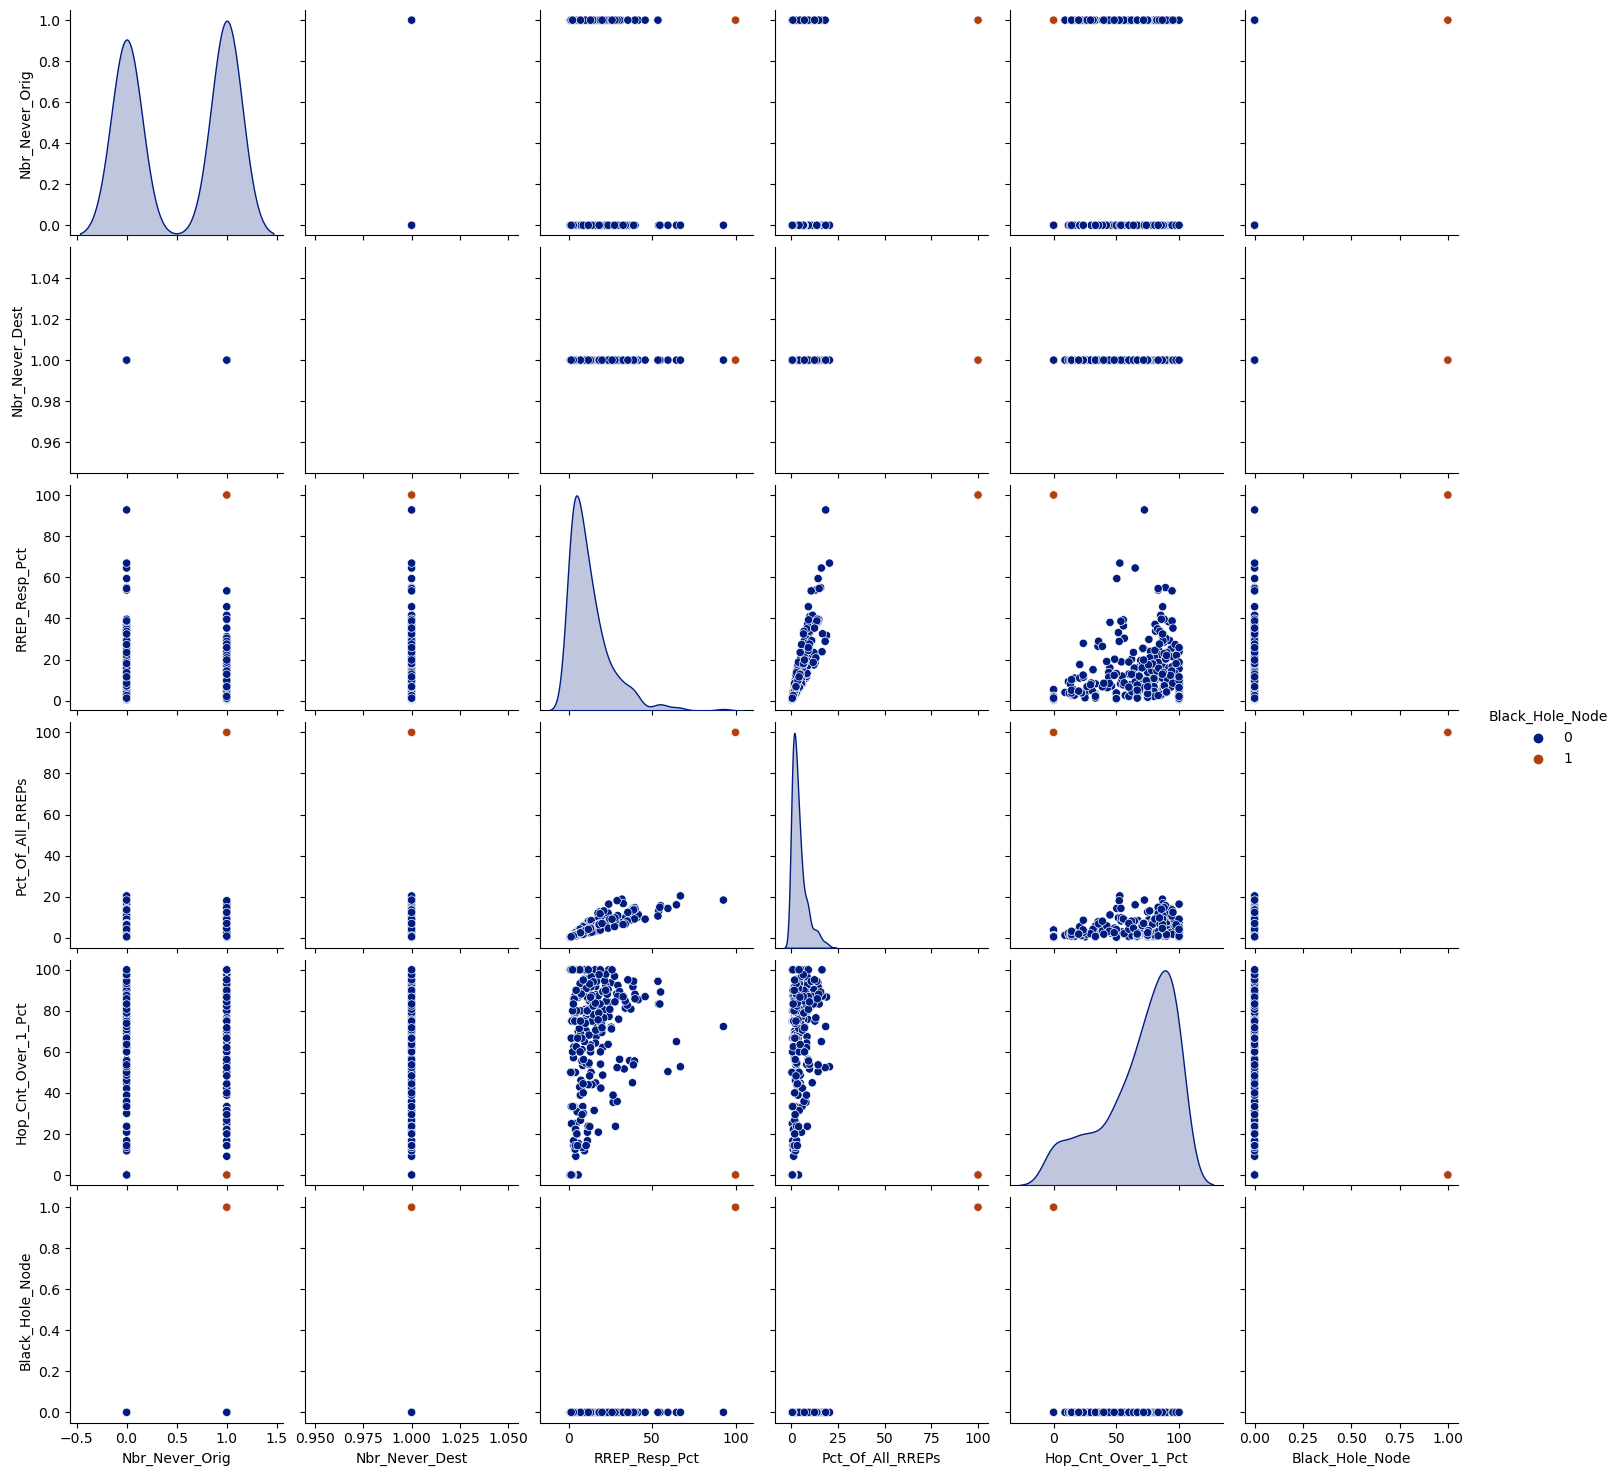

In [26]:
sns.pairplot(data=train, hue='Black_Hole_Node', palette='dark', 
     vars = ['Nbr_Never_Orig', 'Nbr_Never_Dest','RREP_Resp_Pct','Pct_Of_All_RREPs', 
              'Hop_Cnt_Over_1_Pct','Black_Hole_Node'])

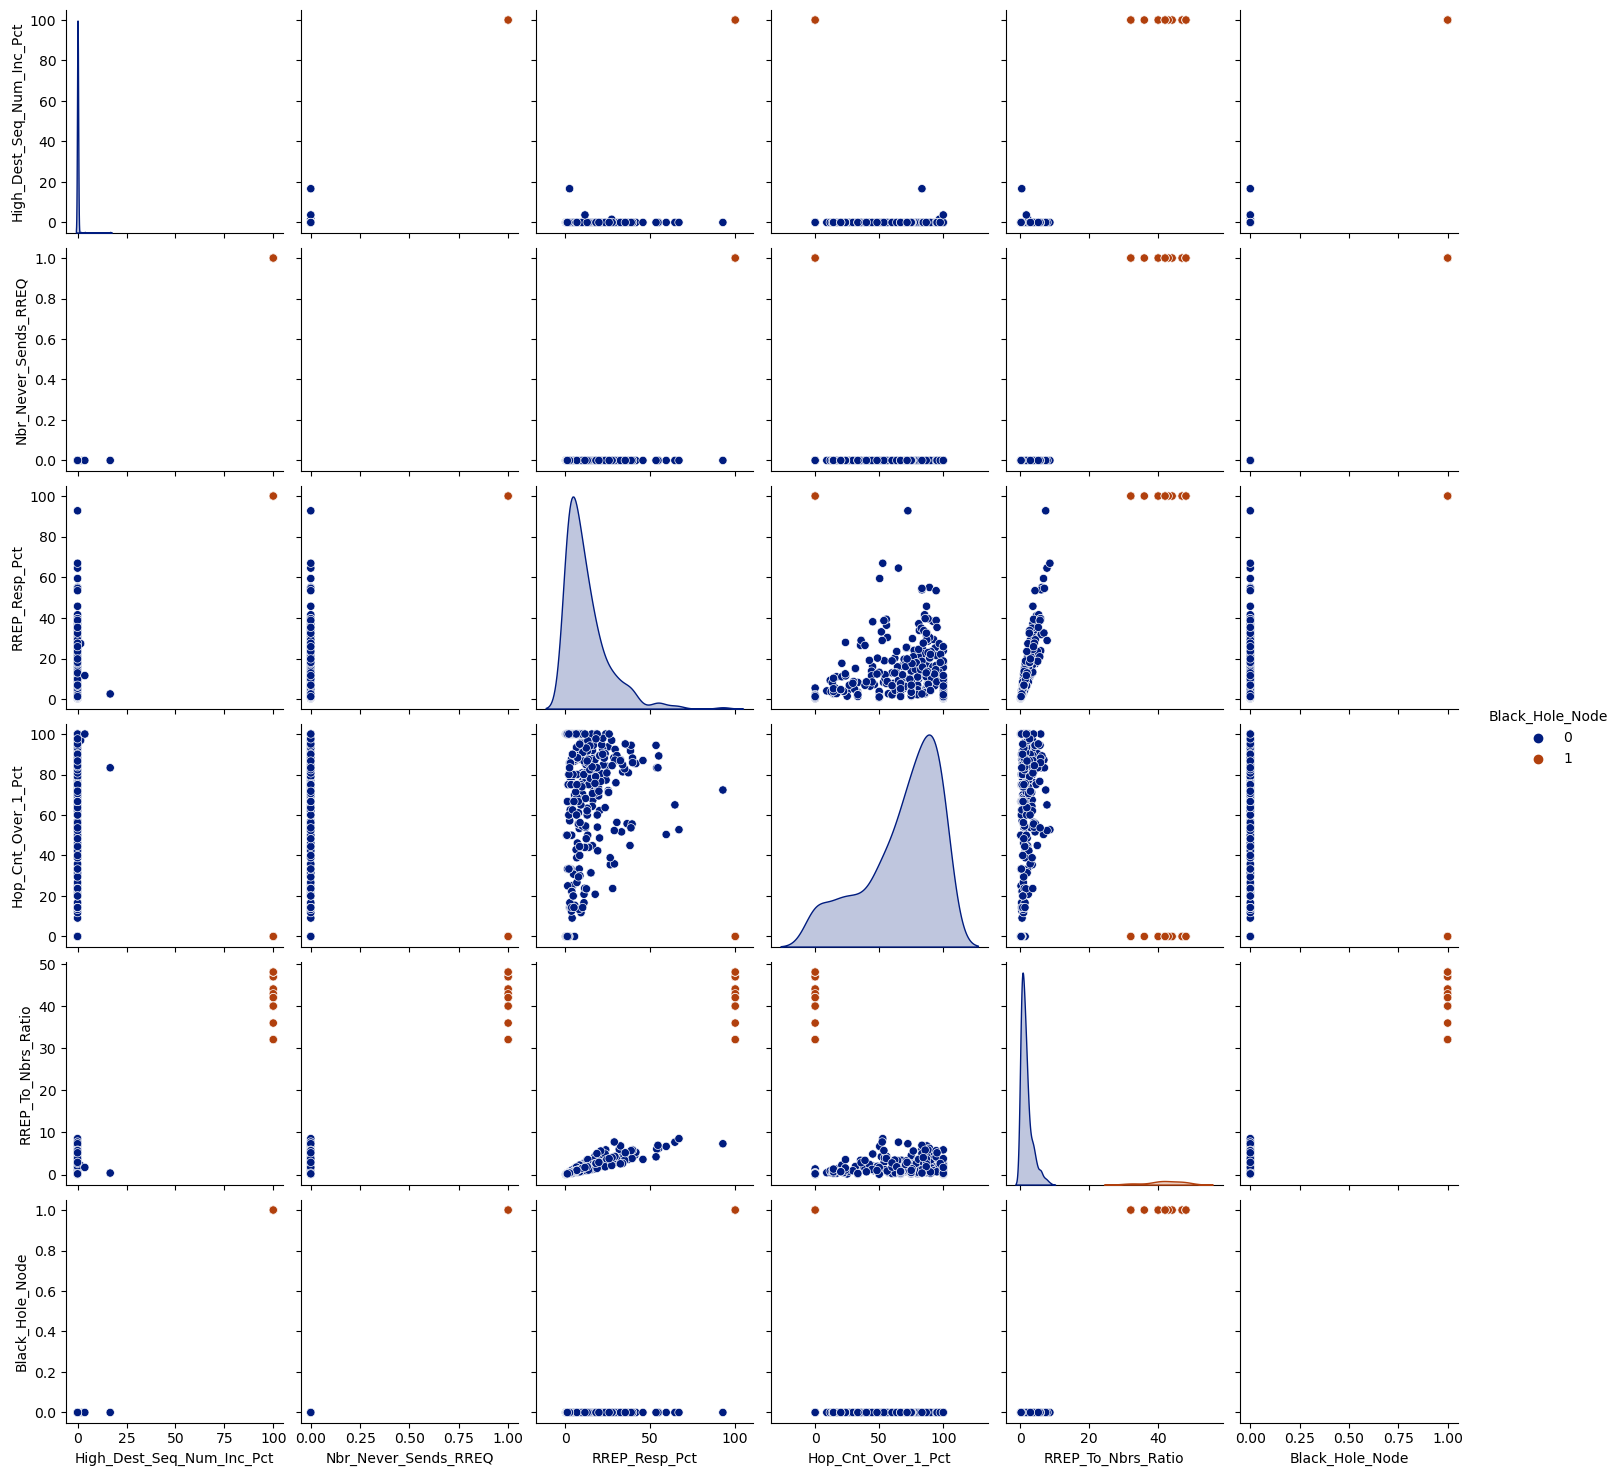

In [27]:
sns.pairplot(data=train, hue='Black_Hole_Node', palette='dark', 
     vars = ['High_Dest_Seq_Num_Inc_Pct','Nbr_Never_Sends_RREQ','RREP_Resp_Pct', 
             'Hop_Cnt_Over_1_Pct', 'RREP_To_Nbrs_Ratio', 'Black_Hole_Node'])

## <span style="color: darkblue;">3. Selection of the Final Feature Set</span>

**Remove the unnecessary features and extract the target variable from the train and test sets**
<br>
<br>
A final set of 10 features was selected based on the criteria mentioned above to be used in the modelling. These features will avoid multicollinearity, include only percentages of responses and exclude features that were used to create other features and have no correlation with expected black hole node behaviour. Examples of removed features include the Subject Node's Number of Neighbours count and the neighbour's Hello count.

In [28]:
X_train = train[['Nbr_Never_Sends_RREQ', 'Nbr_Never_Orig','Nbr_Never_Dest','RREP_Resp_Pct','Pct_Of_All_RREPs',
                 'Hop_Cnt_Over_1_Pct', 'High_Dest_Seq_Num_Inc_Pct','Avg_Resp_Dly_Per_Hop','RERRs_From_Nbr_Pct',
                 'RREP_To_Nbrs_Ratio']]
y_train = train[['Black_Hole_Node']]

X_test = test[['Nbr_Never_Sends_RREQ','Nbr_Never_Orig','Nbr_Never_Dest','RREP_Resp_Pct','Pct_Of_All_RREPs',
               'Hop_Cnt_Over_1_Pct', 'High_Dest_Seq_Num_Inc_Pct','Avg_Resp_Dly_Per_Hop','RERRs_From_Nbr_Pct',
               'RREP_To_Nbrs_Ratio']]
y_test = test[['Black_Hole_Node']]

In [29]:
y_train.head()

,Black_Hole_Node
0,0
1,0
2,1
3,0
4,0


In [30]:
print(y_train['Black_Hole_Node'].value_counts())
print()
print(y_test['Black_Hole_Node'].value_counts())

0    350
1     29
Name: Black_Hole_Node, dtype: int64

0    198
1      7
Name: Black_Hole_Node, dtype: int64


In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Nbr_Never_Sends_RREQ       379 non-null    int64  
 1   Nbr_Never_Orig             379 non-null    int64  
 2   Nbr_Never_Dest             379 non-null    int64  
 3   RREP_Resp_Pct              379 non-null    float64
 4   Pct_Of_All_RREPs           379 non-null    float64
 5   Hop_Cnt_Over_1_Pct         379 non-null    float64
 6   High_Dest_Seq_Num_Inc_Pct  379 non-null    float64
 7   Avg_Resp_Dly_Per_Hop       379 non-null    float64
 8   RERRs_From_Nbr_Pct         379 non-null    float64
 9   RREP_To_Nbrs_Ratio         379 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 29.7 KB


In [32]:
X_train.head()

,Nbr_Never_Sends_RREQ,Nbr_Never_Orig,Nbr_Never_Dest,RREP_Resp_Pct,Pct_Of_All_RREPs,Hop_Cnt_Over_1_Pct,High_Dest_Seq_Num_Inc_Pct,Avg_Resp_Dly_Per_Hop,RERRs_From_Nbr_Pct,RREP_To_Nbrs_Ratio
0,0,1,1,29.83,8.70,75.93,0.0,0.946357,31.48,3.832599
1,0,0,1,38.12,11.11,44.93,0.0,0.649025,63.77,4.894273
2,1,1,1,100.00,100.00,0.00,100.0,0.553015,0.00,44.052863
3,0,1,1,8.29,2.42,53.33,0.0,0.199722,66.67,1.066079
4,0,0,1,1.66,0.48,33.33,0.0,0.407157,100.00,0.211454


In [33]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Nbr_Never_Sends_RREQ       205 non-null    int64  
 1   Nbr_Never_Orig             205 non-null    int64  
 2   Nbr_Never_Dest             205 non-null    int64  
 3   RREP_Resp_Pct              205 non-null    float64
 4   Pct_Of_All_RREPs           205 non-null    float64
 5   Hop_Cnt_Over_1_Pct         205 non-null    float64
 6   High_Dest_Seq_Num_Inc_Pct  205 non-null    float64
 7   Avg_Resp_Dly_Per_Hop       205 non-null    float64
 8   RERRs_From_Nbr_Pct         205 non-null    float64
 9   RREP_To_Nbrs_Ratio         205 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 16.1 KB


### Further Data Exploration

### Examine the imbalance of the target variable

The proportion of normal and malignant nodes are checked in both the training and test datasets.

In [34]:
print('For the training dataset:')
print('The number of normal neighbours are', (y_train['Black_Hole_Node'] == 0).sum(), \
'or', round(100*(y_train['Black_Hole_Node'] == 0).sum()/y_train.shape[0],1), '%')
print('The number of malignant neighbours are', (y_train['Black_Hole_Node'] == 1).sum(), \
'or', round(100*(y_train['Black_Hole_Node'] == 1).sum()/y_train.shape[0],1), '%')

For the training dataset:
The number of normal neighbours are 350 or 92.3 %
The number of malignant neighbours are 29 or 7.7 %


In [35]:
print('For the test dataset:')
print('The number of normal neighbours are', (y_test['Black_Hole_Node'] == 0).sum(), \
'or', round(100*(y_test['Black_Hole_Node'] == 0).sum()/y_test.shape[0],1), '%')
print('The number of malignant neighbours are', (y_train['Black_Hole_Node'] == 1).sum(), \
'or', round(100*(y_test['Black_Hole_Node'] == 1).sum()/y_test.shape[0],1), '%')

For the test dataset:
The number of normal neighbours are 198 or 96.6 %
The number of malignant neighbours are 29 or 3.4 %


Looking above, the split of the target variable cases between the training and test data sets is not perfect but the percentages are close, and both are low. In the train dataset, 93.7% of neighbour rows are normal nodes and 6.3% are malignant neighbours. This is a large imbalance but in the vast majority of AODV networks, it is expected that the number of black hole nodes will be 0 or very small.<br>
In many machine learning classification problems such as this, class imbalance occurs frequently. This tends to bias the algorithm towards the majority class.

## <span style="color: darkblue;">4. Machine Learning Model Design</span>

A Random Forest model and a Support Vector Machine model will be trained and evaluated to see how well they can predict if a neighbouring node is a black hole node.


### Model 1 - Black Hole Node detection using Random Forest Model

Hyperparameters will be tuned by performing a grid search on various hyperparameter combinations in the training set to find the best combination of values.

In [36]:
# Create an instance of the random forest model with 500 trees in the forest.
from sklearn.ensemble import RandomForestClassifier
rfc1 = RandomForestClassifier(n_estimators=200, random_state=2)

In [37]:
# Display the model's parameters.
params = rfc1.get_params()
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}

**Set the hyperparameters for the grid search**

In [38]:
"""
params = {'criterion': ['gini', 'entropy', 'log_loss'], 
          'max_depth': range(1,10), 'max_features': ['sqrt', 'log2', 'None']}
"""

# A reduced set will be used for now to speed up the process
params = {'criterion': ['gini', 'entropy'], 
          'max_depth': range(1,6), 'max_features': ['sqrt', 'log2']}

In [39]:
# Define the grid search

# set up cross validation to split into 10 folds. 
# Repeat 3 times to reduce the randomness of the result.
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

grid1 = GridSearchCV(estimator=rfc1, param_grid=params, 
    cv=cv, scoring='accuracy', error_score=0)

**Determine the best hyperparameter settings by running the grid search**

In [40]:
# get the start time
st = time.time()

# Fit the grid search options to the training data.
grid1.fit(X_train, y_train)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print(str(round(elapsed_time,2)) + " seconds")

93.41 seconds


**Display the optimal values**

In [41]:
print("Best Hyper Parameters:", grid1.best_params_)

Best Hyper Parameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt'}


**Make a prediction and calculate metrics**<br>

In [42]:
# Summarize the results
print("Best: %f using %s" % (grid1.best_score_, grid1.best_params_))
means = grid1.cv_results_['mean_test_score']
stds = grid1.cv_results_['std_test_score']
params = grid1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# The first line of the output above shows the best combination
# of hyperparameters and their resulting accuracy in the training dataset.

Best: 1.000000 using {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt'}
1.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt'}
1.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2'}
1.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt'}
1.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2'}
1.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt'}
1.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2'}
1.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt'}
1.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2'}
1.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt'}
1.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2'}
1.000000 (0.000000) with: {'criterion

In [43]:
# Fit the best hyperparameters to the random forest classifier model.
rfc1 = grid1.best_estimator_

**Display the accuracy score of predicting the training set**

In [44]:
# Check the accuracy score on the training dataset.
score = rfc1.score(X_train, y_train)
print("Accuracy:",score)

Accuracy: 1.0


In [45]:
# Display the model's parameters.
params = rfc1.get_params()
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}

**Predict the classifications on the test set**

In [46]:
y_pred = rfc1.predict(X_test)

**Evaluate the model**

**Display accuracy, precision and recall on the test set**

In [47]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average = 'weighted'))
print("Recall:",metrics.recall_score(y_test, y_pred, average = 'weighted'))
print("F1-score:",metrics.f1_score(y_test, y_pred, average = 'weighted'))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


**Display the classification report for rfc1**

In [48]:
targ_names = ('Normal', 'Black Hole')
class_report_RF = classification_report(y_test, y_pred, target_names = targ_names)
print(class_report_RF)

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       198
  Black Hole       1.00      1.00      1.00         7

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



**Confusion matrix visualization**

A confusion matrix will provide visual information on the model's accuracy.

Text(97.58333333333336, 0.5, 'Predicted label')

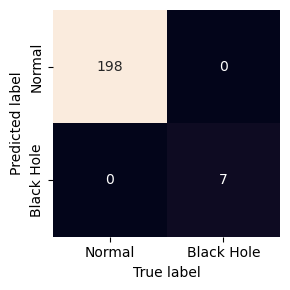

In [49]:
cm1 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,3))

sns.heatmap(cm1.T, square=True, annot=True, fmt='d', cbar=False,
xticklabels=targ_names,
yticklabels=targ_names)
plt.xlabel('True label')
plt.ylabel('Predicted label')

In [50]:
# Compile a list of actual black hole nodes and predicted black hole nodes
test_BHNs = []
predicted_BHNs = []
for idx in range(len(test)):
    if test['Black_Hole_Node'][idx] == 1:
        if not test['Nbr_Node'][idx] in test_BHNs:
            test_BHNs.append(test['Nbr_Node'][idx])
    if y_pred[idx] == 1:
        if not test['Nbr_Node'][idx] in predicted_BHNs:
            predicted_BHNs.append(test['Nbr_Node'][idx])

In [51]:
# Display the simulated and predicted black hole nodes
print('Simulated Black Hole Nodes')
print(test_BHNs)
print()
print('Predicted Black Hole Nodes by the tuned Random Forest Model')
print(predicted_BHNs)

Simulated Black Hole Nodes
['10.1.1.45', '10.1.1.49']

Predicted Black Hole Nodes by the tuned Random Forest Model
['10.1.1.45', '10.1.1.49']


The output above confirms the confusion matrix results that the Random Forest model accurately predicts all of the simulated black hole nodes.

### Evaluation of Model 1, Random Forest with grid search
As has been mentioned already, it must be stressed that due to not having completely correct NS-3 simulation output files for the AODV network, some of the data has been manually manipulated to better simulate the most obvious behaviour of a black hole node. As a result, the simulations have proved to be extremely accurate, however the creation of the highest correlating features is encouraging and it is expected that the dataset conversion process and the machine learning process will be highly successful at detecting black hole nodes.<br>
<br>
It must be pointed out that accurate NS-3 simulations of the AODV network and the behaviour of the black hole nodes are required so that the accuracy of the entire process can be determined and also improved.



#### Save the trained random forest model
The best DTC model will be saved in the working directory as follows:

In [52]:
with open('rfc_1_model', 'wb') as f:
    pickle.dump(rfc1,f)
    f.close()

This model can be easily be reimported again with the following code.

In [53]:
with open('rfc_1_model', 'rb') as f:
    rfc_2 = pickle.load(f)
    f.close()

### Model 2 - Black Hole Node detection using Support Vector Machine Model

**Standardization**<br>
Standardization is a feature scaling process of subtracting the mean value from each feature and then dividing the difference by the feature's standard deviation. Distance algorithms including SVM are adversely affected by the difference in the range of features. They use distances between data points to determine their similarity. For example, looking at the output of train.describe() above in section B1 the feature 'RREQs_Sent_To_Nbr' has a mean value of 203.6 and a standard deviation of 50.18. Further on, the feature 'Avg_Resp_Dly_Per_Hop' has a mean value of 0.578 and a standard deviation of 0.345. As both features have vastly different scales, more weight in the algorithm will be given to 'RREQs_Sent_To_Nbr'. This will bias the performance of the SVM algorithm towards 'RREQs_Sent_To_Nbr' Ideally, all features should be treated with equal weight. To achieve this, all features will be scaled so that they all have a similar magnitude.
Tree based algorithms are not affected by the difference in scale of the features. A decision tree only splits a node based on a single feature.
Instead of directly invoking a scale function, a Scikit-Learn feature called the Transformer API will be used.

In [54]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)

The scaler object now has the saved means and standard deviations for each feature in the training set. The result will be displayed

In [55]:
X_train_scaled = scaler.transform(X_train)

In [56]:
# Display the mean value of each feature after scaling.
print(X_train_scaled.mean(axis=0))

[-2.81217442e-17  0.00000000e+00  0.00000000e+00  1.87478294e-17
  4.33543556e-17 -2.57782655e-17  5.15565310e-17 -3.28087015e-17
 -8.90521898e-17 -2.34347868e-17]


In [57]:
X_train.head()

,Nbr_Never_Sends_RREQ,Nbr_Never_Orig,Nbr_Never_Dest,RREP_Resp_Pct,Pct_Of_All_RREPs,Hop_Cnt_Over_1_Pct,High_Dest_Seq_Num_Inc_Pct,Avg_Resp_Dly_Per_Hop,RERRs_From_Nbr_Pct,RREP_To_Nbrs_Ratio
0,0,1,1,29.83,8.70,75.93,0.0,0.946357,31.48,3.832599
1,0,0,1,38.12,11.11,44.93,0.0,0.649025,63.77,4.894273
2,1,1,1,100.00,100.00,0.00,100.0,0.553015,0.00,44.052863
3,0,1,1,8.29,2.42,53.33,0.0,0.199722,66.67,1.066079
4,0,0,1,1.66,0.48,33.33,0.0,0.407157,100.00,0.211454


In [58]:
X_train['Nbr_Never_Dest'].value_counts()

1    379
Name: Nbr_Never_Dest, dtype: int64

The output above shows that the mean value of each feature is now effectively 0.

In [59]:
# Display the standard deviation of each feature after scaling.
print(X_train_scaled.std(axis=0))

[1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]


The output above shows that the standard deviation of each feature is now 1.

<span style="color: red;">**It must be noted that the feature 'Nbr_Never_Dest' is currently erronous in the simulations and always has a value of 1. As a result of this, its standard deviation is 0 above. It is kept in the list of final features as it is expected that once corrected, this will be a strong indicator of whether a node is a malicious or not.**</span>

Next, the same scaler object is used to transform the test set using the exact same means and standard deviations used to transform the training set. If the test set was scaled separately, it would not be a fair evaluation of the model.

In [60]:
X_test_scaled = scaler.transform(X_test)

In [61]:
# Display the mean value of each feature in the test set after scaling.
print(X_test_scaled.mean(axis=0))

[-0.15939436 -0.05571298  0.         -0.14087155 -0.11059108  0.24410317
 -0.15806592  0.03868128  0.07767402 -0.14967006]


The mean values of the features of the test set are now close to 0 but are not perfectly centred.  This is expected. The test set is transformed using the means from the training set.

In [62]:
# Display the standard deviation of each feature in the test set after scaling.
print(X_test_scaled.std(axis=0))

[0.68317811 1.00509717 0.         0.7707373  0.71586364 0.89969715
 0.68357643 1.08058315 1.10960653 0.65534889]


The standard deviation of each feature in the test set is now close to 1 as is expected.

### Parameter Tuning
Cross validation will also be performed for the svm model with standardized data to find the optimum settings for the hyperparameters.

In [63]:
# Create an instance of the model.
svc = SVC()

**Parameters setup:**<br>
Four kernels are chosen and various hyperparameters pertaining to them will be tested to determine what is the optimum combination of settings for this dataset.

In [64]:
"""
param_grid = [{'C': [0.0, 0.1, 0.5, 1, 5, 10], 
               'kernel': ['linear'], 'class_weight': ['balanced']},
  {'C': [0.0, 0.1, 0.5, 1, 5, 10], 'kernel': ['rbf'],
   'gamma': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
   'class_weight': ['balanced']},        
{'C': [0.0, 0.1, 0.5, 1, 5, 10], 'kernel': ['poly'], 
 'gamma': ['scale', 0, 0.00001, 0.0001, 0.0005, 0.001, 0.01, 0.1, 0.005, 0.05, 0.5], 
 'degree': [1,2,3,4,5,6], 'coef0': [0.0, 0.1, 0.5, 1, 5, 10], 
 'class_weight': ['balanced'], 'max_iter': [10000]},
 {'C': [0.0, 0.1, 0.5, 1, 5, 10], 'kernel': ['sigmoid'],
  'gamma': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
  'coef0': [0.0, 0.1, 0.5, 1, 5, 10], 'class_weight': ['balanced']} ]
"""
# A reduced set will be used for now to speed up the process
param_grid = [{'C': [0.0, 0.1, 0.5, 1], 
               'kernel': ['linear'], 'class_weight': ['balanced']},
  {'C': [0.0, 0.1, 0.5, 1, 5, 10], 'kernel': ['rbf'],
   'gamma': [0.01, 0.05, 0.1, 0.5, 1],
   'class_weight': ['balanced']},        
{'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['poly'], 
 'gamma': ['scale', 0.01, 0.1, 0.005, 0.05, 0.5], 
 'degree': [1,2,3,4], 'coef0': [0.1, 0.5, 1, 5, 10], 
 'class_weight': ['balanced'], 'max_iter': [1000]}
 ]


In [65]:
# Define the grid search

# set up cross validation to split into 10 folds. Repeat 2 times
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

# Load the model and all parameters into the grid search.
grid2 = GridSearchCV(estimator=svc, param_grid=param_grid, cv=cv, 
                    scoring='accuracy', error_score=0)

In [66]:
# get the start time
st = time.time()

# Test and fit the grid search options to the training data.
grid2.fit(X_train_scaled, y_train)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print(str(round(elapsed_time,2)) + " seconds")

20.43 seconds


**Display the best hyperparameter settings**

In [67]:
print("Best Hyper Parameters:", grid2.best_params_)

Best Hyper Parameters: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}


**Make a prediction and calculate metrics**

In [68]:
svc_1 = grid2.best_estimator_

In [69]:
# Summarize the results
print("Best: %f using %s" % (grid2.best_score_, grid2.best_params_))
means = grid2.cv_results_['mean_test_score']
stds = grid2.cv_results_['std_test_score']
params = grid2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# The first line of the output above shows 
# the best combination of hyperparameters and 
# their resulting accuracy in the training dataset.

Best: 1.000000 using {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 0.0, 'class_weight': 'balanced', 'kernel': 'linear'}
1.000000 (0.000000) with: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
1.000000 (0.000000) with: {'C': 0.5, 'class_weight': 'balanced', 'kernel': 'linear'}
1.000000 (0.000000) with: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 0.0, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 0.0, 'class_weight': 'balanced', 'gamma': 0.05, 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 0.0, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 0.0, 'class_weight': 'balanced', 'gamma': 0.5, 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 0.0, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
1.000000 (0.000000) with: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}
1.000

**Display the accuracy score of predicting on the training set**

In [70]:
score = svc_1.score(X_train_scaled,y_train)
print("Accuracy:",score)

Accuracy: 1.0


**Predict the classifications on the test set**

In [71]:
y_pred_2=svc_1.predict(X_test_scaled)

**Display the classification report of svc_1**

In [72]:
print(classification_report(y_test, y_pred_2, target_names=targ_names))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       198
  Black Hole       1.00      1.00      1.00         7

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



**Evaluate the model**

In [73]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_2))
print("Precision:",metrics.precision_score(y_test, y_pred_2, average = 'weighted'))
print("Recall:",metrics.recall_score(y_test, y_pred_2, average = 'weighted'))
print("F1-score:",metrics.f1_score(y_test, y_pred_2, average = 'weighted'))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


**Create a confusion Matrix**

In [74]:
cm2 = confusion_matrix(y_test, y_pred_2)

Text(97.58333333333336, 0.5, 'Predicted label')

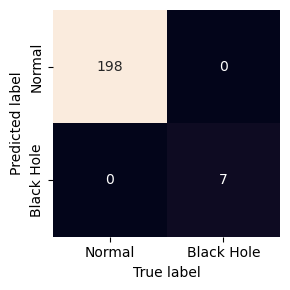

In [75]:
plt.figure(figsize=(5,3))

sns.heatmap(cm2.T, square=True, annot=True, fmt='d', cbar=False,
xticklabels=targ_names,
yticklabels=targ_names)
plt.xlabel('True label')
plt.ylabel('Predicted label')

In [76]:
# Compile a list of actual black hole nodes and predicted black hole nodes
test_BHNs = []
predicted_BHNs = []
for idx in range(len(test)):
    if test['Black_Hole_Node'][idx] == 1:
        if not test['Nbr_Node'][idx] in test_BHNs:
            test_BHNs.append(test['Nbr_Node'][idx])
    if y_pred_2[idx] == 1:
        if not test['Nbr_Node'][idx] in predicted_BHNs:
            predicted_BHNs.append(test['Nbr_Node'][idx])


In [77]:
# Display the simulated and predicted black hole nodes
print('Simulated Black Hole Nodes')
print(test_BHNs)
print()
print('Predicted Black Hole Nodes by the tuned SVM Model')
print(predicted_BHNs)

Simulated Black Hole Nodes
['10.1.1.45', '10.1.1.49']

Predicted Black Hole Nodes by the tuned SVM Model
['10.1.1.45', '10.1.1.49']


The output above confirms the confusion matrix results, that the SVM model accurately predicts and identifies all of the simulated black hole nodes.

### Visualize Support Vectors

In [78]:
svc_1.support_vectors_

array([[-0.28784917, -1.12670363,  0.        ,  1.81971705,  0.3495895 ,
        -0.2969659 , -0.29004911,  0.17870112, -0.59766236,  0.35384171],
       [-0.28784917,  0.88754484,  0.        ,  0.37545415,  0.26045118,
        -0.31022048, -0.29004911,  0.20254279, -0.423763  ,  0.27990217],
       [-0.28784917, -1.12670363,  0.        ,  2.80091933,  0.27091524,
         0.29346547, -0.29004911,  0.42951655, -0.49325749,  0.24134066],
       [ 3.47404167,  0.88754484,  0.        ,  3.0767044 ,  3.4361006 ,
        -1.88600951,  3.47214279,  0.01861788, -0.8127527 ,  2.51591584],
       [ 3.47404167,  0.88754484,  0.        ,  3.0767044 ,  3.4361006 ,
        -1.88600951,  3.47214279,  0.28207612, -0.8127527 ,  2.51591584],
       [ 3.47404167,  0.88754484,  0.        ,  3.0767044 ,  3.4361006 ,
        -1.88600951,  3.47214279, -1.52458505, -0.8127527 ,  2.51591584]])

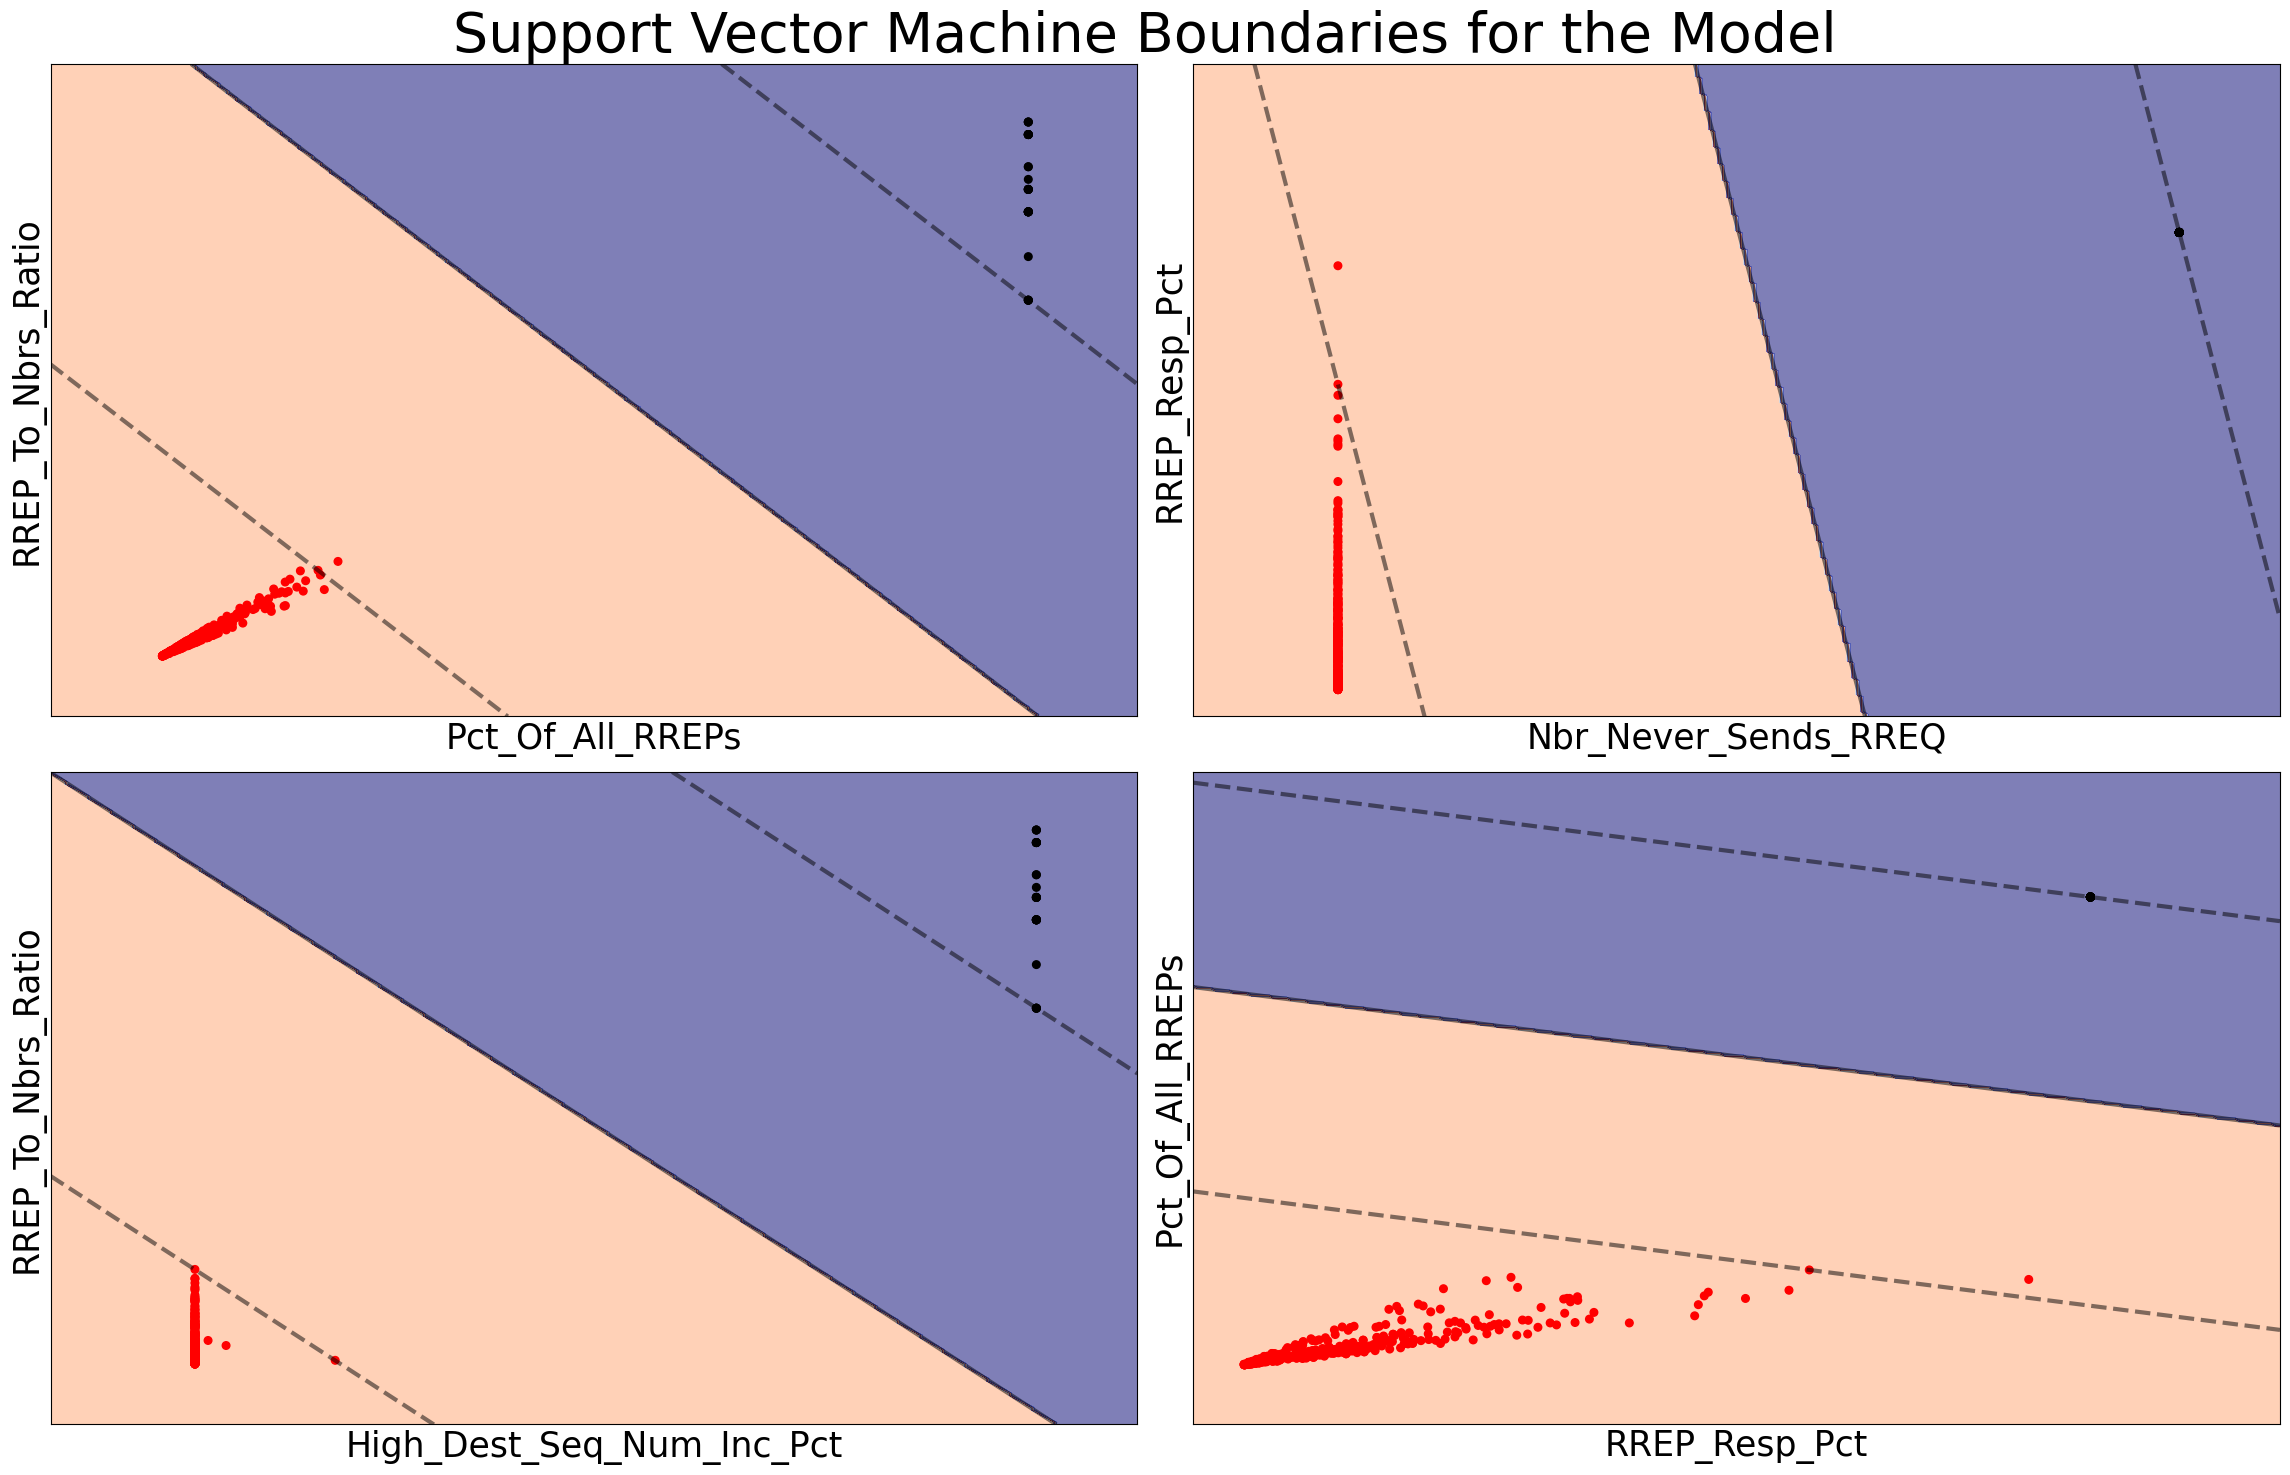

In [80]:
# Acknowledgement to Scikit-learn for this code. It has been modified from:
# https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html

# The best parameters from the grid search for model svc_1 are given below:
# Best: 1.000000 using {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}

# Create the 2D datasets
X1 = X_train_scaled[:, [4,9]]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset 
X1x = X_train.columns[4]
X1y = X_train.columns[9]
X2 = X_train_scaled[:, [0,3]]  # we only take the first two features.
X2x = X_train.columns[0]
X2y = X_train.columns[3]
X3 = X_train_scaled[:, [6,9]]  # we only take the first two features.
X3x = X_train.columns[6]
X3y = X_train.columns[9]
X4 = X_train_scaled[:, [3,4]]  # we only take the first two features.
X4x = X_train.columns[3]
X4y = X_train.columns[4]

y = y_train['Black_Hole_Node']

h = .02  # step size in the mesh

# As the model svc_1 is for 10 dimensions (features), for a 2D plot the model will be 
# run on 2 features only and refitted with the same hyperparameters.
# Create an instance of SVC and fit out data. 
# The model parameters are kept the same as the best fit from the grid search.
C = 0.1  # SVM regularization parameter

# create a mesh to plot in
x_min, x_max = X1[:, 0].min() - 0.5, X1[:, 0].max() + 0.5
y_min, y_max = X1[:, 1].min() - 0.5, X1[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
title = 'SVM boundary for Model svc_1'
x_labels = [X1x, X2x, X3x, X4x]
y_labels = [X1y, X2y, X3y, X4y]


plt.suptitle('Support Vector Machine Boundaries for the Model', fontsize = 40)
for i, X_set in enumerate((X1, X2, X3, X4)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    svc = SVC(kernel='linear', C=C).fit(X_set, y)
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # create a mesh to plot in

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.flag, alpha=0.5)

    # Plot the support vectors
    xy = np.vstack([xx.ravel(), yy.ravel()]).T
    Z2 = svc.decision_function(xy).reshape(xx.shape)

    plt.contour(xx, yy, Z2, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'], linewidths=3)

    # Plot also the training points
    plt.scatter(X_set[:, 0], X_set[:, 1], c=y, s=30, cmap=plt.cm.flag)
    plt.xlabel(x_labels[i], fontsize = 25)
    plt.ylabel(y_labels[i], fontsize = 25)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    #plt.title(title, fontsize = 20)

plt.show()

**\* Denotes a black hole node**<br>
<span style="color: red;">**\* Denotes a normal node**

The plots above show a similar model run (the same hyperparameters) as svc_1 but with a dataset of just two features to produce 2D  scatter plots and their corresponding support vectors. Several features are compared in the scatter plots. <br><br>
The decision boundary is the line that separates the colours and the support vectors can be seen on either side of it.<br><br>
With a "dumb" black hole node as is simulated in these datasets, it can be seen that there is a large separation in distance between the normal and black hole nodes, making the classififcation decision very easy. 

### Evaluation of Model 2 
### Support Vector Machine using standardized dataset with tuned hyperparameters

Similar to the Random Forest model, it must be stressed that due to not having completely correct NS-3 simulation output files for the AODV network, some of the data has been manually manipulated to better simulate the most obvious behaviour of a black hole node. As a result, the simulations have proved to be extremely accurate, however the creation of the highest correlating features is encouraging and it is expected that the dataset conversion process and the machine learning process will be highly successful at detecting black hole nodes.<br>
<br>
It must be pointed out that accurate NS-3 simulations of the AODV network and the behaviour of the black hole nodes are required so that the accuracy of the entire process can be determined and also improved.

### Save the support vector machine model
The model will be saved in the working directory as follows. It can now be loaded and applied without having to be refitted.

In [81]:
with open('svc_1', 'wb') as f:
    pickle.dump(svc_1,f)
    f.close()

This model can be easily be reimported again with the following code.

In [82]:
with open('svc_1', 'rb') as f:
    svc_2 = pickle.load(f)
    f.close()

## <span style="color: darkblue;">5. Machine Learning Conclusion</span>
Both models detected the black hole nodes in the sample training and test sets with 100% accuracy. Naturally, much more further testing is required once the NS-3 simulations are accurately simulating the AODV networks and black hole nodes. The first step is to continue working on producing accurate network simulations that behave according to the AODV protocol. This is a difficult step and will involve a great deal of work, but it is essential in order to prove the validity of the entire machine learning process.

As pointed out, if the black hole nodes behave as is expected, it would appear that machine learning can successfully be applied to the network data to determine if there are malicious nodes present in the network.
